In [1]:
import matplotlib as mpl
# ^^^ pyforest auto-imports - don't write above this line
import os
import pandas as pd
import numpy as np
import sklearn.tree
from sklearn.model_selection import RandomizedSearchCV
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

sns.set_palette('Set2') #set colorblind-friendly palette for seaborn
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 1000000000)
mpl.rc('figure', max_open_warning = 0)

In [2]:
#This class essentially houses all of the functions necessary to run a driver analysis
class driver_analysis:
    
    '''
    
    This class contains a collection of all functions written for conducting a driver analysis for any app or all of suite
    
    '''
    
    def __init__(self, df):
        
        df = df
        
    #remove columns from data that are missing all or almost all of their data (in this case more than half)
    def remove_completely_missing_columns(df, missing_tolerance):
    
        '''this function removes all columns that are missing more than x% of all values'''
    
    
        #create missingness df
        missingness = pd.DataFrame(df.isna().sum()).reset_index().rename(columns = {'index':'column', 0:'num_missing'})

        print(f'shape before deleting missing columns: {df.shape}')
        #find columns that are missing all of their data and drop them
        all_missing = []
        for idx, row in missingness.iterrows():
            #filter out columns missing most of their values
            if row[1] > (missing_tolerance * df.shape[0]):
                all_missing.append(row[0])

        #drop these columns
        df = df.drop([x for x in all_missing], axis = 1)

        print(f'shape after deleting missing columns: {df.shape}')
    
        return df
    
    
    def target_encoder(df, column, target, index=None, method='mean'):

        """

        Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal
        with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable
        with just one new numerical variable. Each category or level of the categorical variable is represented by a
        summary statistic of the target for that level.

        Args:

            df (pandas df): Pandas DataFrame containing the categorical column and target.
            column (str): Categorical variable column to be encoded.
            target (str): Target on which to encode.
            index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold
            method (str): Summary statistic of the target. Mean, median or std. deviation.
            
        Returns:

            arr: Encoded categorical column.



        """



        index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied



        if method == 'mean':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].mean())

        elif method == 'median':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].median())

        elif method == 'std':

            encoded_column = df[column].map(df.loc[index].groupby(column)[target].std())

        else:

            raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))



        return encoded_column
    
    #updated this for app from suite, just had to add in a couple of columns that weren't in this originally
    def throw_out_useless_features(df):
    
        '''
    
        There are several features that Manoj doesn't want in the analysis (i.e. locators since every geo feature rolls up to region), so I am creating a function
        that takes care of this since I have to do it so often
    
        '''
    
        print(f'Shape before: {df.shape}')
        
        #get rid of features that we know from Surface analysis that Manoj definitely does not want in the model
        features = pd.DataFrame(df.columns).rename(columns = {0:'features'})

        features = features[~features['features']\
        .str.contains('Feedback_ID|Date|Feedback_Verbatim|Feedback_SurveyName|Scale|Locale|Feedback_SurveyFlightName|'\
                  'IsValid|Language|SourceVerbatim|Ocv|Country|State|OsName|User_SurveyId|Enabled|Tenant_Region|Device_SysVolSizeMB')]

        features = features[~features['features']\
        .str.contains('User_CommercialTenantName|MSSalesTopParent|Market|ResellerName|Tenant_Name|City|'\
                  'OrgName|OrgId|Unnamed|TenantName|TenantID|OfferList|Time|LastUpdated|Feedback_Platform')]

        features = features[~features['features']\
        .str.contains('Postal|Currency|SubsidiaryName|SubRegion|Cluster|RegionName|AreaName|Big|VerticalName|'\
                  'SegmentName|GroupName|ATUName|Territory|TenantId|Month|Rating_y|App_y|AppModeExt|Host')]

        features = features[~features['features']\
        .str.contains('CompanyName|GPName|SignupRegion|AreaName|TeamName|Verbatim_Details|Verbatim_Themes|NPS|'\
                  'Fork|NgramThemePrediction|DistrictId|Since|Start|End|Ngrams|Rating_x|PremierSchedule|SubsidiaryId|Tenant_Tenure')]

        #subset the df 
        df = df[[x for x in features['features']]]
    
        print(f'Shape after throwing out useless features: {df.shape}')
    
        return df
    
    def plot_cats(df, nps, subset = None):
    
        '''
    
        This function takes a df as an argument, it plots categorical features, if a categorical feature has more than 40 levels then it simply
        performs a groupby and chooses the top 20 from that feature's value counts, indications of this will be in the title of the resulting plot
    
        '''
    
        #loop through and plot each cat feature with less than 40 levels
        for feature in df.columns:
        
            if (df[feature].nunique() < 40) & (feature != 'Feedback_RatingValue') & (df[feature].dtype == 'O'): # don't want to plot feedback rating value
        
                plt.figure(figsize = (20, 7))
        
                df.groupby(df[feature]).Feedback_RatingValue.mean().sort_values().plot(kind = 'bar')
        
                plt.title(f'NPS by {feature}', fontsize = 16)
        
                plt.xlabel(f'{feature}', fontsize = 14)
        
                plt.ylabel('Average NPS Score', fontsize = 14)
            
                plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
            
                #if a feature has more than 20 levels, rotate this much    
                if df[feature].nunique() > 20:
            
                    plt.xticks(rotation = 80)
                
                else:
            
                    plt.xticks(rotation = 40)
            
                #add annotated legend depending on if data is suite or app
                if subset == 'web':
                
                    plt.legend(labels = ['2020 AVG Web NPS'], fontsize = 14)
            
                elif subset == 'windows':
                
                    plt.legend(labels = ['2020 AVG Windows NPS'], fontsize = 14)
                
            elif (df[feature].nunique() > 40) & (df[feature].dtype == 'O'):
            
                #plotting top 20 device models by NPS score 
                top_20 = pd.DataFrame(df[f'{feature}'].value_counts().nlargest(20)).index
            
                #creating df for levels in the top 20
                plt_df = df[df[f'{feature}'].isin(top_20)]
            
                #creating figure size
                plt.figure(figsize = (20, 7))
            
                #plotting on a categorical variable using groupby
                plt_df.groupby(f'{feature}').Feedback_RatingValue.mean().sort_values().plot(kind = 'bar')
            
                #create title
                plt.title(f'NPS by Top 20 {feature}', fontsize = 16)
            
                #create y label
                plt.ylabel('Average NPS Score', fontsize = 14)
            
                #create x label
                plt.xlabel(f'{feature}', fontsize = 14)
            
                plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
            
                if subset == 'web':
            
                    plt.legend(labels = ['2020 AVG Web NPS'], fontsize = 14)
                
                elif subset == 'windows':
                
                    plt.legend(labels = ['2020 AVG Windows NPS'], fontsize = 14)
                
                if df[feature].nunique() > 20:
            
                    plt.xticks(rotation = 80)
                
                else:
            
                    plt.xticks(rotation = 20);
                #setting x tick rotation for longer names to be visible and not overlap
                
    def plot_office_build_by_age(df, nps):
    
        '''
    
        This function plots office build sorted by age
    
        '''

        a = pd.DataFrame(df['Device_OfficeBuild'].value_counts().nlargest(20)).reset_index().sort_values('index').rename(columns = {'index':'OfficeBuild', 'Device_OfficeBuild':
                                                                                                                                      'number'})

        b = pd.DataFrame(df.groupby('Device_OfficeBuild').Feedback_RatingValue.mean()).reset_index()

        b = b[b['Device_OfficeBuild'].isin(a['OfficeBuild'])].sort_values('Device_OfficeBuild', ascending = False)

        pd.DataFrame(b.groupby('Device_OfficeBuild').Feedback_RatingValue.mean()).sort_values(by = 'Device_OfficeBuild', ascending = False).plot(kind = 'bar', figsize = (15, 8))
        plt.xlabel('Office Build Sorted by Age', fontsize = 16)
        plt.ylabel('Average NPS', fontsize = 16)
        plt.title('NPS by Office Build (Sorted by Age)', fontsize = 22)
        plt.axhline(nps, linestyle = '--', color = 'tab:blue')
        plt.legend(labels = ['2020 AVG NPS'], fontsize = 14)
        plt.xticks(rotation = 45)
            
    def numeric_plot_structure(nps, df, feature, subset, title, xlabel, bins, labels = None, method = None):
    
        '''
    
        This function takes a df, feature, binsize (or individual bins when using cut), labels (again, if using cut pass a list of labels), and method
        It then plots the feature accordingly
    
        '''
    
        #if you are going to use qcut
        if method is 'qcut':
            
            plt.figure(figsize = (15, 7))
                
            ax = df.groupby(pd.qcut(df[feature], bins, duplicates = 'drop')).Feedback_RatingValue.mean().plot(kind = 'bar')
                
            plt.title(title, fontsize = 16)
                
            plt.xlabel(xlabel, fontsize = 14)
                
            plt.ylabel('Average NPS Score')
            
            if nps is not None:
        
                plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
        
                if subset == 'web':
            
                    ax.legend(labels = ['2020 AVG Web NPS'], fontsize = 14)
            
                elif subset == 'windows':
            
                    ax.legend(labels = ['2020 AVG Windows NPS'], fontsize = 14)
            
            plt.xticks(list(range(0, bins)), labels, rotation = 50);
        
        #if you are going to use cut (for descretizing features with greater control over bins)
        elif method is 'cut':
            
            plt.figure(figsize = (15, 7))
                
            ax = df.groupby(pd.cut(df[feature], bins = bins, labels = labels)).Feedback_RatingValue.mean().plot(kind = 'bar')
                
            plt.title(title, fontsize = 16)
                
            plt.xlabel(xlabel, fontsize = 14)
                
            plt.ylabel('Average NPS Score', fontsize = 14)
            
            if nps is not None:
            
                plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
        
                if subset == 'web':
            
                    ax.legend(labels = ['2020 AVG Web NPS'], fontsize = 14)
        
                elif subset == 'windows':
            
                    ax.legend(labels = ['2020 AVG Windows NPS'], fontsize = 14)
            
            plt.xticks(rotation = 20);
            
    def plot_nums(nps, df, feature, subset):
        
        '''
        
        This function serves as a binner and labeler for the numeric plot structure function above, essentially this is a culmination of my work creating
        numeric plots from scratch for a series of other drivers. The features contained in this function are those which have been identified from my 
        analysis on other projects, and some of them carry over to this one. So that I didn't have to re-create the wheel, I have included them all here and 
        will be adding more as I go. 
        
        Args: the df that you are in and the feature that you want to plot, better to use this in a loop over a dataframe of the top 10 features
        
        Output: numerically binned plots
        
        '''
        
        if feature == 'Device_SysVolSizeMB':
        
            #plotting System Size MB
            driver_analysis.numeric_plot_structure(nps, df, 'Device_SysVolSizeMB', subset,
                  'NPS by System Size (GB)', 'System Volume Size (GB)', bins = [0, 30000, 100000, 500000, 1000000, 1000000000000000], 
                  labels= ['< 30GB', '30GB-100GB', '100GB-500GB', '500GB-1,000GB', '1,000GB+'], method = 'cut')
            
        elif feature == 'Device_SysVolFreeSpaceMB':
        
            #plotting SysVolFreeSpace
            driver_analysis.numeric_plot_structure(nps, df, 'Device_SysVolFreeSpaceMB', subset, 'NPS by System Free Space (GB)', 'Free Space (GB)',
                          bins = [0, 30000, 60000, 90000, 170000, 200000, 350000, 500000, 750000, 10000000000000], 
                              labels = ['< 30GB', '30GB-60GB', '60GB-90GB', '90GB-170GB', '170GB-200GB', '200GB-350GB', '350GB-500GB', '500GB-750GB', '750GB+'], method = 'cut')
        
        elif feature == 'Device_ProcSpeedMHz':
        
            #plotting Device Processing Speed
            driver_analysis.numeric_plot_structure(nps, df, 'Device_ProcSpeedMHz', subset, 'NPS by Device Processing Speed (MHz)', 'Device Processing Speed (MHz)', 
                     bins = [0, 1500, 2000, 2500, 3000, 3500, 4000, 4500], labels = ['< 1500', '1,500-2,000', '2,000-2,500', '2,500-3,000', '3,000-3,500',
                                                                                    '3,500-4,000', '4,000-4,500'], method = 'cut')
        
        elif feature == 'User_Consumer_TenureDays':
            
            driver_analysis.numeric_plot_structure(nps, df, 'User_Consumer_TenureDays', subset, 'NPS by Consumer Tenure', 'Consumer Tenure', 
                      bins = [0, 100, 250, 365, 730, 1095, 1460, 1825, 2190, 2571], labels = ['< 3 Months', '3-9 Months', 
                    '9 Months-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years', '6+ Years'], method = 'cut')
            
        elif feature == 'Device_HorizontalResolution':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Device_HorizontalResolution', subset, 'NPS by Horizontal Resolution', 'Horizontal Resolution', 
                     bins = [0, 1400, 1800, 2000, 2500, 5000, 10000],
                      labels = ['< 1,400', '1,400-1,800', '1,800-2,000', '2,000-2,500', '2,500-5,000', '5,000+'], method = 'cut')
            
        elif feature == 'Device_RamMB':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Device_RamMB', subset, 'Device RAM (GB)', 'Device RAM (GB)', bins = [0, 4000, 8000, 16000, 50000, 100000],
                              labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'], method = 'cut')
            
        elif feature == 'Tenant_Odin_TotalUsers':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_Odin_TotalUsers', subset, 'NPS by Odin Total Users', 'Odin Total Users', 
                      bins = [0, 5, 50, 150, 750, 5000, 15000, 40000, 100000, 200000, 10000000000000],
                          labels = ['< 5', '5-50', '50-150', '150-750', '750-5,000', '5-15,000', '15-40,000', '40-100,000', '100-200,000', '200,000+'], method = 'cut')
            
        elif feature == 'Tenant_Tenure':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_Tenure', subset, 'NPS by Tenant Tenure Days', 'Tenant Tenure Days',
                          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
                          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')
            
        elif feature == 'Tenant_PaidAvailableUnits':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_PaidAvailableUnits', subset, 'NPS by Paid Available Units', 'Available Units', 
                  bins = [0, 5, 30, 100, 300, 2500, 10000, 30000, 200000, 10000000000000000],
                  labels = ['< 5', '5-30', '30-100', '100-300', '300-2,500', '1,500-10,000', '10-30,000', '30-200,000', '200,000+'], method = 'cut')
            
        elif feature == 'Tenant_EXOEnabledUsers':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_EXOEnabledUsers', subset, 'NPS by EXO Enabled Users', 'Enabled Users', 
                      bins = [0, 10, 50, 200, 1000, 5000, 10000, 50000, 150000, 10000000000000],
                      labels = ['< 10', '10-50', '50-200', '200-1,000', '1-5,000', '5-10,000', '10-50,000', '50-150,000', '150,000+'], method = 'cut')
            
        elif feature == 'Tenant_LYOEnabledUsers':
        
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_LYOEnabledUsers', subset, 'NPS by LYO Enabled Users', 'Enabled Users', 
                      bins = [0, 12, 55, 400, 3000, 15000, 70000, 1000000000000],
                      labels = ['< 12', '12-55', '55-400', '400-3,000','3-15,000', '15-70,000', '70,000+'], method = 'cut')
            
        elif feature == 'User_Commercial_TotalEnabledUsers':
        
            driver_analysis.numeric_plot_structure(nps, df, 'User_Commercial_TotalEnabledUsers', subset, 'NPS by Commercial Total Enabled Users', 'Total Enabled Users', 
                      bins = [0, 20, 100, 300, 2000, 10000, 30000, 80000, 200000, 1000000000000],
                      labels = ['< 20', '20-100', '100-300', '300-2,000', '2-10,000', '10-30,000', '30-80,000', '80-200,000', '200,000+'], method = 'cut')
            
        elif feature == 'Tenant_TotalEnabledUsers':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_TotalEnabledUsers', subset, 'NPS by Total Enabled Users', 'Total Enabled Users', 
                      bins = [0, 20, 100, 250, 1000, 5000, 20000, 50000, 100000, 250000, 100000000000000],
                      labels = ['< 20', '20-100', '100-250', '250-1,000', '1-5,000', '5-20,000', '20-50,000', '50-100,000', '100-250,000', '250,000+'], method = 'cut')
            
        elif feature == 'Tenant_SPOEnabledUsers':
            
            driver_analysis.numeric_plot_structure(nps, df, 'Tenant_SPOEnabledUsers', subset, 'NPS by SPO Enabled Users', 'SPO Enabled Users', 
                 bins = [0, 10, 100, 1000, 5000, 10000, 15000, 30000, 75000, 150000, 1000000000],
                  labels = ['< 10', '10-100', '100-1,000', '1-5,000', '5-10,000', '10-15,000', '15-30,000', '30-75,000', '75-150,000', '150,000+'], method = 'cut')
            
                
    def plot_promoter_and_detractor_percentages(df):
        
        '''
        
        This function plots the percentage of each group's detractors, passives, and promoters
        
        '''
    
        for feature in df.select_dtypes(include = 'object').columns:
    
            if df[feature].nunique() > 40:
            
                top_20 = pd.DataFrame(df[feature].value_counts().nlargest(20)).index
            
                plt_df = df[df[feature].isin(top_20)]
            
                counts = (plt_df.groupby(['Feedback_RatingValue'])[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
            
                plt.figure(figsize = (25, 8))
            
                ax = sns.barplot(x = feature, y = 'percentage', hue = counts['Feedback_RatingValue'].map({-100:'Detractors', 0:'Passives', 100:'Promoters'}), data = counts,
                        order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
            
                plt.title(f'Top 20 {feature} Detractors, Passives, and Promoters', fontsize = 22)
            
                plt.xticks(rotation = 70, fontsize = 10)
                
                plt.xlabel(f'{feature}', fontsize = 14)
                
                plt.ylabel('Percentage', fontsize = 14)
                
                plt.legend(fontsize = 16)

            
            elif df[feature].nunique() < 40:
            
                counts = (df.groupby(['Feedback_RatingValue'])[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
            
                plt.figure(figsize = (25, 8))
            
                ax = sns.barplot(x = feature, y = 'percentage', hue = counts['Feedback_RatingValue'].map({-100:'Detractors', 0:'Passives', 100:'Promoters'}), data = counts,
                        order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
            
                plt.title(f'{feature} Detractors, Passives, and Promoters', fontsize = 22)
            
                plt.xticks(rotation = 70, fontsize = 10)
                
                plt.xlabel(f'{feature}', fontsize = 14)
                
                plt.ylabel('Percentage', fontsize = 14)
                
                plt.legend(fontsize = 16)
                
    def plot_build_age(nps, df, ages, subset, bins, labels):
    
        '''
    
        Becuase we want to look at office build in terms of the age of the build, we must enter them in here, this function plots ages of builds, cut up into 
        the appropriate bins
    
        '''

        #needed to go online to get age of build in months, then match those to the exact build
        office_builds = pd.DataFrame(df.Device_OfficeBuild.value_counts().nlargest(20)).reset_index().rename(columns = {'index':'Device_OfficeBuild'})
        
        office_builds['months_old'] = ages

        build_nps = pd.DataFrame(df.groupby('Device_OfficeBuild').Feedback_RatingValue.agg({'mean', 'size'})).sort_values('size', ascending=False)[:20].reset_index()

        build_nps['age'] = [x for x in office_builds['months_old']]

        build_nps['age'] = pd.cut(build_nps['age'], bins= bins, labels = labels)
    
        plt.figure(figsize = (12, 7))
        
        #sns.barplot(x = 'age', y = 'mean', data = build_nps, ci = False)
        
        build_nps.groupby('age')['mean'].mean().plot(kind = 'bar')
        
        plt.title('NPS by Build Age', fontsize = 22)
        
        plt.xlabel('Build Age (in months)', fontsize = 16)
        
        plt.ylabel('NPS', fontsize = 16)
        
        plt.axhline(y=nps, linestyle = '--', color = 'tab:blue')
        
        if subset is 'windows':
            
            leg = plt.legend(labels = ['2020 AVG Windows NPS'])
            
        elif subset is 'web':
            
            leg = plt.legend(labels = ['2020 AVG Web NPS'])
            
        leg_lines = leg.get_lines()
        
        plt.setp(leg_lines, linestyle = '--', color = 'tab:blue', linewidth = 2)
        
        plt.xticks(rotation = 0)
        
    def generate_nps_trends():
        
        '''
        
        This function takes a list of filepaths, included in the body of the function here, iterates through each filepath, and plots lineplot nps trends for each
        of these filepaths. So in each filepath, there should be a separate csv file for each segment (i.e. in Word, there should be a 'windows_nps', 'web_nps',
        'windows_consumer_nps', 'windows_comedu_nps', 'windows_nonedu_nps', 'web_comedu_nps', 'web_nonedu_nps'). If each directory contains those files, then this function
        will work perfectly, if the filepaths are not set up that way then it wont. Each of these csv files in the filepath should have three columns (as taken from kusto
        using the query below), 1. 'avg_nps', 2. 'year', 3. 'month' -- this structure will show the average nps score of the product by year and month
        
        ARGS: There are no arguments for this function, simply write it out
        
        Output: a series of plots that show NPS trends over time (lineplots)
        
        Kusto Query:
        
        #this first query is for the app overall, either web or windows desktop
        
        SELECT AVG(CAST(Feedback_RatingValue AS FLOAT)) AS avg_nps, DATEPART(year, Feedback_DateTime) AS year, DATEPART(month, Feedback_DateTime)
        AS month FROM EndUserAppNPS()
        WHERE Feedback_Source LIKE '%{product}%'
        AND Feedback_Platform LIKE '%Windows%' AND Feedback_DateTime >= CAST('2019-05-01' AS datetime)
        GROUP BY DATEPART(year, Feedback_DateTime), DATEPART(month, Feedback_DateTime)
        ORDER BY year, month
        
        #this query can be adapted for commercial edu and commercial nonedu
        
        SELECT AVG(CAST(Feedback_RatingValue AS FLOAT)) AS avg_nps, 
        DATEPART(year, Feedback_DateTime) AS year, DATEPART(month, Feedback_DateTime)
        AS month FROM EndUserAppNPS()
        WHERE Feedback_UserType = 'Commercial' AND User_Commercial_HasEducation = 1 AND Feedback_Source LIKE '%Teams%' 
        AND Feedback_Platform LIKE '%Windows%' AND Feedback_DateTime >= CAST('2019-05-01' AS datetime)
        GROUP BY DATEPART(year, Feedback_DateTime), DATEPART(month, Feedback_DateTime)
        ORDER BY year, month
        
        #this one is for consumer
        
        SELECT AVG(CAST(Feedback_RatingValue AS FLOAT)) AS avg_nps, DATEPART(year, Feedback_DateTime) 
        AS year, DATEPART(month, Feedback_DateTime)
        AS month FROM EndUserAppNPS()
        WHERE Feedback_UserType = 'Consumer' AND Feedback_Source LIKE '%Word%' AND Feedback_Platform LIKE '%Windows%'
        AND Feedback_DateTime >= CAST('2019-05-01' AS datetime)
        GROUP BY DATEPART(year, Feedback_DateTime), DATEPART(month, Feedback_DateTime)
        ORDER BY year, month
        
        #this last one is the kusto query for windows desktop or web in full suite NPS
        
        EndUserO365NPS(platform = 'Web')
        |where Feedback_DateTime >= datetime('2019-05-01')
        |summarize avg_nps = avg(Feedback_RatingValue) by year = getyear(Feedback_DateTime), month = getmonth(Feedback_DateTime)
        |order by year asc, month asc
        
        #for suite consumer
        
        EndUserO365NPS(platform = 'Web')
        |where Feedback_DateTime >= datetime('2019-05-01') and Feedback_UserType == 'Consumer'
        |summarize avg_nps = avg(Feedback_RatingValue) by year = getyear(Feedback_DateTime), month = getmonth(Feedback_DateTime)
        |order by year asc, month asc
        
        #for suite commercial edu or nonedu
        
        EndUserO365NPS(platform = 'Windows Desktop')
        |where Feedback_DateTime >= datetime('2019-05-01') and Feedback_UserType == 'Commercial' and User_Commercial_HasEducation == 1
        |summarize avg_nps = avg(Feedback_RatingValue) by year = getyear(Feedback_DateTime), month = getmonth(Feedback_DateTime)
        |order by year asc, month asc
        
        '''
    
        filepaths = ['C:\\Users\\fulto\\Desktop\\Driver Analysis\\Suite', 'C:\\Users\\fulto\Desktop\\Driver Analysis\\Excel', 'C:\\Users\\fulto\\Desktop\\Driver Analysis\\Word',
            'C:\\Users\\fulto\\Desktop\\Driver Analysis\\PP', 'C:\\Users\\fulto\\Desktop\\Driver Analysis\\Outlook', 'C:\\Users\\fulto\\Desktop\\Driver Analysis\\Teams']
    
        from itertools import cycle
        
        lines = ['-', '-.', '--', ':']
        
        linecycler = cycle(lines)
    
        for filepath in filepaths:
        
            if filepath.endswith('Teams'):
    
                for filename in os.listdir(filepath):
        
                    os.chdir(filepath)
        
                    if filename.startswith('windows'):
            
                        df = pd.read_csv(f'{filename}')
            
                        ax = df['avg_nps'].plot(figsize = (18, 10), linewidth = 4, linestyle = next(linecycler))
            
                        plt.title(f'{filepath[39:]} Windows 10 Month NPS Trend', fontsize = 22)
            
                        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'March', 
                                                           'April', 'May', 'June'], fontsize = 16, rotation = 15)
                
                        ax.legend(fontsize = 'xx-large', labels = ['Commercial Edu', 'Commercial Non-Edu',  'Overall Windows'])
                    
                        plt.xlabel('NPS Trend (2019 - 2020)', fontsize = 16)
                    
                        plt.ylabel('NPS', fontsize = 16)
            
                plt.show()
            
            else:
            
                for filename in os.listdir(filepath):
                
                    os.chdir(filepath)
        
                    if filename.startswith('windows'):
            
                        df = pd.read_csv(f'{filename}')
            
                        ax = df['avg_nps'].plot(figsize = (18, 10), linewidth = 4, linestyle = next(linecycler))
            
                        plt.title(f'{filepath[39:]} Windows 13 Month NPS Trend', fontsize = 22)
            
                        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'March', 
                                                           'April', 'May', 'June'], fontsize = 16, rotation = 15)
                
                        ax.legend(fontsize = 'xx-large', labels = ['Commercial Edu', 'Consumer', 'Commercial Non-Edu', 'Overall Windows'])
                    
                        plt.xlabel('NPS Trend (2019 - 2020)', fontsize = 16)
                    
                        plt.ylabel('NPS', fontsize = 16)
                
                plt.show()
    
        for filepath in filepaths:
        
            if filepath.endswith('Teams'):
            
                for filename in os.listdir(filepath):
        
                    os.chdir(filepath)
        
                    if filename.startswith('web'):
            
                        df = pd.read_csv(f'{filename}')
            
                        ax = df['avg_nps'].plot(figsize = (18, 10), linewidth = 4, linestyle = next(linecycler))
            
                        plt.title(f'{filepath[39:]} Web 10 Month NPS Trend', fontsize = 22)
            
                        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'March', 
                                                           'April', 'May', 'June'], fontsize = 16, rotation = 15)
                    
                        ax.legend(fontsize = 'xx-large', labels = ['Commercial Edu', 'Commercial Non-Edu', 'Overall Web'])
                    
                        plt.xlabel('NPS Trend (2019 - 2020)', fontsize = 16)
                    
                        plt.ylabel('NPS', fontsize = 16)
            
                plt.show()
    
            else:
            
                for filename in os.listdir(filepath):
        
                    os.chdir(filepath)
        
                    if filename.startswith('web'):
            
                        df = pd.read_csv(f'{filename}')
            
                        ax = df['avg_nps'].plot(figsize = (18, 10), linewidth = 4, linestyle = next(linecycler))
            
                        plt.title(f'{filepath[39:]} Web 13 Month NPS Trend', fontsize = 22)
            
                        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'March', 
                                                           'April', 'May', 'June'], fontsize = 16, rotation = 15)
                
                        ax.legend(fontsize = 'xx-large', labels = ['Commercial Edu', 'Consumer', 'Commercial Non-Edu', 'Overall Web'])
                    
                        plt.xlabel('NPS Trend (2019 - 2020)', fontsize = 16)
                    
                        plt.ylabel('NPS', fontsize = 16)
            
                plt.show()
                
    def get_top_10_feats(df, web_or_windows = None, subset = None):
    
        '''
    
        This function takes an input of a dataframe of feature importances from the modeling function, then it subsets the df for those features only, returning a 
        df of 10 features and NPS scores
    
        '''
    
        top_10 = [x for x in df.iloc[:10, 0].reset_index()['Features']]
    
        new_df = web_or_windoes[web_or_windows['NgramThemePredictions'] == subset]
    
        new_df = pd.concat([new_df[top_10], new_df['Feedback_RatingValue']], axis = 1)
    
        return new_df
    
    def web_and_windows_slicer(filepath, csv):
    
        '''
    
        This function takes a filepath and a csv filename as arguments and slices that df up into web and windows datasets, this is useful if you are performing analyses on 
        web and windows dfs only, it provides you with 6 dfs that you can name whatever you want that will be 3 web and 3 windows dfs, one each for consumer,
        commercial edu, and commercial nonedu, if your dataset is missing windows or web data then it will simply result in an empty df, but you must have 6 dfs for it to 
        unpack into or else it will throw an error
    
        Args: filepath = filepath where csv file is contained, csv = name of csv file in that filepath
    
        '''
    
        os.chdir(filepath)
    
        df = pd.read_csv(csv, low_memory = False)
    
        web = df[df['Feedback_Platform'].str.contains('Web')]
    
        windows = df[df['Feedback_Platform'].str.contains('Windows')]
    
        web_consumer = web[web['Feedback_UserType'] == 'Consumer']
    
        web_com = web[web['Feedback_UserType'] == 'Commercial']
    
        web_comedu = web_com[web_com['User_Commercial_HasEducation'] == 1.0]
    
        web_nonedu = web_com[web_com['User_Commercial_HasEducation'] == 0.0]
    
        windows_consumer = windows[windows['Feedback_UserType'] == 'Consumer']
                        
        windows_com = windows[windows['Feedback_UserType'] == 'Commercial']
                        
        windows_comedu = windows_com[windows_com['User_Commercial_HasEducation'] == 1.0]
                        
        windows_nonedu = windows_com[windows_com['User_Commercial_HasEducation'] == 0.0]
                        
        dfs = [web_consumer, web_comedu, web_nonedu, windows_consumer, windows_comedu, windows_nonedu]
                        
        dfs = [driver_analysis.remove_completely_missing_columns(df, .75) for df in dfs]
                        
        web_consumer, web_comedu, web_nonedu, windows_consumer, windows_comedu, windows_nonedu = dfs
                        
        return web_consumer, web_comedu, web_nonedu, windows_consumer, windows_comedu, windows_nonedu
    
    def read_entire_csv(filepath, filename):
        
        '''
        
        This function reads in a csv without slicing it up into consumer, commercial, at all and removes features with a high amount of missingness.
        This function is most useful for running an analysis on an entire dataset such as suite web, suite windows, etc.
        
        '''
        
        import os
        
        os.chdir(filepath)
        
        df = pd.read_csv(filename, low_memory = False, encoding='latin-1')
        
        df = driver_analysis.remove_completely_missing_columns(df, .75)
        
        return df
    
    def get_detractors_and_promoters(filepath, csv):
        
        '''
        
        This function splits up web and windows dfs (if they both exist) into detractors, passives, and promoters so that we can run the driver analysis,
        or plot these subsets, in more fine-grained detail. The arguments for this function are the same as the previosu function. This function returns a list
        of dfs that needs to be unpacked upon use of the function. i.e. df1, df2, df3 = dfs
        
        '''
        
        os.chdir(filepath)
    
        df = pd.read_csv(csv, low_memory = False)
    
        web = df[df['Feedback_Platform'].str.contains('Web')]
    
        windows = df[df['Feedback_Platform'].str.contains('Windows')]
    
        web_consumer = web[web['Feedback_UserType'] == 'Consumer']
    
        web_com = web[web['Feedback_UserType'] == 'Commercial']
    
        web_comedu = web_com[web_com['User_Commercial_HasEducation'] == 1.0]
    
        web_nonedu = web_com[web_com['User_Commercial_HasEducation'] == 0.0]
    
        windows_consumer = windows[windows['Feedback_UserType'] == 'Consumer']
                        
        windows_com = windows[windows['Feedback_UserType'] == 'Commercial']
                        
        windows_comedu = windows_com[windows_com['User_Commercial_HasEducation'] == 1.0]
                        
        windows_nonedu = windows_com[windows_com['User_Commercial_HasEducation'] == 0.0]
                        
        dfs = [web_consumer, web_comedu, web_nonedu, windows_consumer, windows_comedu, windows_nonedu]
                        
        dfs = [driver_analysis.remove_completely_missing_columns(df, .75) for df in dfs]
            
        for df in dfs:
                
            web_consumer_detractors = web_consumer[web_consumer['Feedback_RatingValue'] == -100]
            
            web_consumer_passives = web_consumer[web_consumer['Feedback_RatingValue'] == 0]
            
            web_consumer_promoters = web_consumer[web_consumer['Feedback_RatingValue'] == 100]
            
            web_comedu_detractors = web_comedu[web_comedu['Feedback_RatingValue'] == -100]
            
            web_comedu_passives = web_comedu[web_comedu['Feedback_RatingValue'] == 0]
            
            web_comedu_promoters = web_comedu[web_comedu['Feedback_RatingValue'] == 100]
            
            web_nonedu_detractors = web_nonedu[web_nonedu['Feedback_RatingValue'] == -100]
            
            web_nonedu_passives = web_nonedu[web_nonedu['Feedback_RatingValue'] == 0]
            
            web_nonedu_promoters = web_nonedu[web_nonedu['Feedback_RatingValue'] == 100]
            
            windows_consumer_detractors = windows_consumer[windows_consumer['Feedback_RatingValue'] == -100]
            
            windows_consumer_passives = windows_consumer[windows_consumer['Feedback_RatingValue'] == 0]
            
            windows_consumer_promoters = windows_consumer[windows_consumer['Feedback_RatingValue'] == 100]
            
            windows_comedu_detractors = windows_comedu[windows_comedu['Feedback_RatingValue'] == -100]
            
            windows_comedu_passives = windows_comedu[windows_comedu['Feedback_RatingValue'] == 0]
            
            windows_comedu_promoters = windows_comedu[windows_comedu['Feedback_RatingValue'] == 100]
            
            windows_nonedu_detractors = windows_nonedu[windows_nonedu['Feedback_RatingValue'] == -100]
            
            windows_nonedu_passives = windows_nonedu[windows_nonedu['Feedback_RatingValue'] == 0]
            
            windows_nonedu_promoters = windows_nonedu[windows_nonedu['Feedback_RatingValue'] == 100]
            
        if web_consumer_detractors.shape[1] == 0:
            
            dfs = [windows_consumer_detractors, windows_consumer_passives, windows_consumer_promoters, windows_comedu_detractors, windows_comedu_passives,
                  windows_comedu_promoters, windows_nonedu_detractors, windows_nonedu_passives, windows_nonedu_promoters]
            
        else:
            
            dfs = [web_consumer_detractors, web_consumer_passives, web_consumer_promoters, web_comedu_detractors, web_comedu_passives, web_comedu_promoters,
                  web_nonedu_detractors, web_nonedu_passives, web_nonedu_promoters, windows_consumer_detractors, windows_consumer_passives, windows_consumer_promoters, 
                  windows_comedu_detractors, windows_comedu_passives, windows_comedu_promoters, windows_nonedu_detractors, windows_nonedu_passives, windows_nonedu_promoters]
            
        return dfs       
    
    #model with LightGBM -- which accepts missingness with no special adaptation, this will truncate this process significantly
    def find_drivers(df, title):
        
        '''
        
        This function mean target encodes a set of features, then runs them through two separate Light GBM models, the first extracts all feature importances
        and the second uses the top 10 features from the first to run a model that returns the feature importances for those ten variables controlling for
        one another (using the # of times that the decision trees split on that variable). The final output of this function are two plots of feature importances, along with 
        the df containing a subset of the data for the top 10 features.
        
        Args: arguments in this function are a df and the title of the feature importances plot that you want
        
        '''
        
        #some of these dfs might not have "Feedback_Rating" in them
        if 'Feedback_Rating' in df.columns:
            
            features = df.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
            
        else:
            
            features = df.drop('Feedback_RatingValue', axis = 1)
        
        target = df['Feedback_RatingValue']
        
    
        #import lightgbm
        import lightgbm as lgb
        
        combined = driver_analysis.throw_out_useless_features(pd.concat([features, target], axis = 1))
        
        for col in combined.columns:
            
            if combined[col].dtype == 'O':
                
                combined[col] = driver_analysis.target_encoder(combined, column = col, target = 'Feedback_RatingValue', index = None, method = 'mean')
    
                encoded_features = combined.drop('Feedback_RatingValue', axis = 1)
    
                target = combined['Feedback_RatingValue']
        
        #instantiate model
        LGBMModel = lgb.LGBMClassifier(objective = 'multiclass').fit(encoded_features, target)
        
        #----This code below can be uncommented if you want to perform a gridsearch, but the results are essentially the same without tuning----
        
#         param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
#                   'max_depth': [2,5,10,25,None]}
    
#         CV_lgb = RandomizedSearchCV(estimator=LGBMModel, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
    
#         CV_lgb.fit(encoded_features, target)
        
#         n_estimators, max_depth = CV_lgb.best_params_.values()

#         LGBMModel = lgb.LGBMClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth, objective = 'multiclass').fit(encoded_features, target)

        #getting feature importances greatest to least
        learners = LGBMModel.feature_importances_.argsort()[::-1]
    
        features_df = pd.DataFrame(encoded_features.columns[learners], LGBMModel.feature_importances_[learners])
    
        #only using features that had more than .015 splits
        feature_importances = features_df[features_df.index>0.005]
    
        #get top 10 features from feature importances to be fed into the next model
        top_10 = [x for x in feature_importances.iloc[:10, 0]]
    
        #subset features by the top 10 -- this begins the second stage of modeling
        encoded_features = encoded_features[top_10]
    
        #instantiate model
        LGBMModel = lgb.LGBMClassifier(objective = 'multiclass').fit(encoded_features, target)
        
        #----again, this code below can be used for a second tuning session----
        
#         param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
#                   'max_depth': [2,5,10,25,None]}
    
#         CV_lgb = RandomizedSearchCV(estimator=LGBMModel, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
    
#         CV_lgb.fit(encoded_features, target)
        
#         n_estimators, max_depth = CV_lgb.best_params_.values()

#         LGBMModel = lgb.LGBMClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth, objective = 'multiclass').fit(encoded_features, target)

        #getting feature importances greatest to least
        learners = LGBMModel.feature_importances_.argsort()[::-1]
        
        features_df = pd.DataFrame(encoded_features.columns[learners], LGBMModel.feature_importances_[learners])
    
        #only using features that had more than .005 splits
        feature_importances = encoded_features[encoded_features.index>0.005]
        
        important_df = pd.concat([features[top_10], target], axis = 1)
    
        importance_plot = lgb.plot_importance(LGBMModel, figsize = (12, 8), importance_type = 'split', ignore_zero = True, grid = False, title = title)
        
        features_df = features_df.iloc[:10, :]

        features_df.rename(columns = {0:'one'}, inplace = True)

        features_df.reset_index(inplace = True)

        features_df.rename(columns = {'index':'two'}, inplace = True)
        
        #create plot that uses feature importance splits to create percentage, per Manoj's request
        features_df['two'] = [x/sum(features_df['two']) for x in features_df['two']]
        
        plt.figure(figsize = (12, 7))
        ax = sns.barplot(y = 'one', x = 'two', data = features_df, color = 'tab:blue') 
        plt.title(title, fontsize = 22)
        plt.xlabel('Importance Meter! (How Often a Variable was Used by the Model)', fontsize = 18)
        plt.ylabel('Features', fontsize = 18)
    
        return important_df

In [3]:
#unpack dfs into single vars--no web here, so we can name those arbitrarily
a, b, c, outlook_windows_consumer_drivers, outlook_windows_comedu_drivers, outlook_windows_nonedu_drivers = \
        driver_analysis.web_and_windows_slicer('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Outlook', 'Outlook_Windows.csv')

shape before deleting missing columns: (0, 321)
shape after deleting missing columns: (0, 321)
shape before deleting missing columns: (0, 321)
shape after deleting missing columns: (0, 321)
shape before deleting missing columns: (0, 321)
shape after deleting missing columns: (0, 321)
shape before deleting missing columns: (58151, 321)
shape after deleting missing columns: (58151, 74)
shape before deleting missing columns: (12656, 321)
shape after deleting missing columns: (12656, 252)
shape before deleting missing columns: (73978, 321)
shape after deleting missing columns: (73978, 252)


In [4]:
#find drivers for outlook windows as a whole, without breaking it down into consumer, commercial
outlook_windows = driver_analysis.read_entire_csv('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Outlook', 'Outlook_Windows.csv')

shape before deleting missing columns: (145181, 321)
shape after deleting missing columns: (145181, 248)


Shape before: (145181, 247)
Shape after throwing out useless features: (145181, 159)


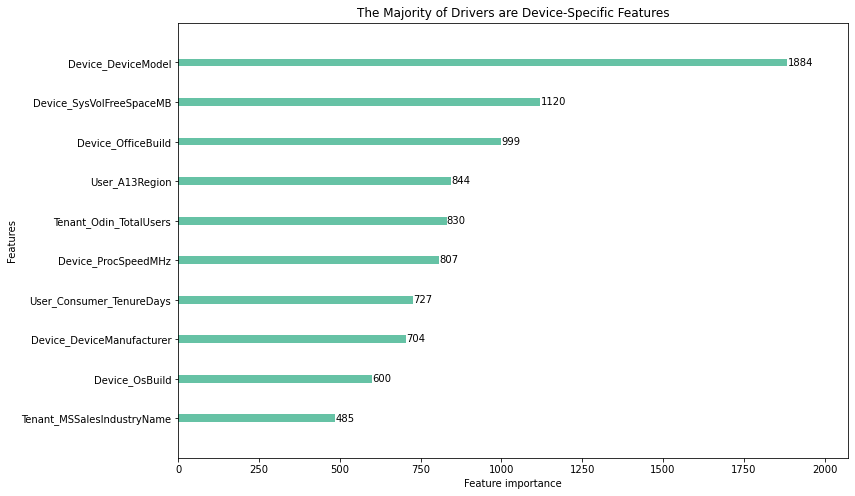

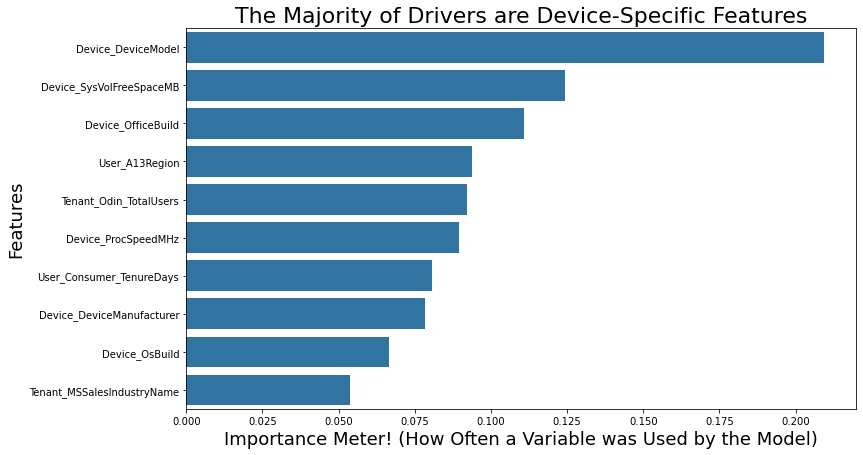

In [5]:
outlook_windows_drivers = driver_analysis.find_drivers(outlook_windows, 'The Majority of Drivers are Device-Specific Features')

In [6]:
#force everything to an object so I can plot it
outlook_windows_drivers['Device_SysVolFreeSpaceMB'] = pd.cut(outlook_windows_drivers['Device_SysVolFreeSpaceMB'], bins = [0, 30000, 60000, 90000, 170000, 200000, 350000, 500000, 750000, 10000000000000], 
                              labels = ['< 30GB', '30GB-60GB', '60GB-90GB', '90GB-170GB', '170GB-200GB', '200GB-350GB', '350GB-500GB', '500GB-750GB', '750GB+'])
outlook_windows_drivers['Device_ProcSpeedMHz'] = pd.cut(outlook_windows_drivers['Device_ProcSpeedMHz'], bins = [0, 1500, 2000, 2500, 3000, 3500, 4000, 4500], labels = ['< 1500', '1,500-2,000', '2,000-2,500', '2,500-3,000', '3,000-3,500',
                                                                                    '3,500-4,000', '4,000-4,500'])

#outlook_windows_drivers = outlook_windows_drivers.apply(lambda x: x.astype(str))

In [7]:
def janky_plot_function(df, feature):
    
    a = pd.DataFrame(df.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
    
    plt.figure(figsize = (20, 10))
    sns.barplot(x = feature, y = 'percentage', hue= a['Feedback_RatingValue'].map({-100:'Detractors', 0:'Passives', 100:'Promoters'}), data = a, order = a.iloc[a[a['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
    plt.title(f'{feature} Detractors, Passives, and Promoters', fontsize = 22)
    plt.xlabel(feature, fontsize = 16)
    plt.ylabel('Percentage', fontsize = 16)
    plt.legend(fontsize = 12)


Shape before: (58151, 73)
Shape after throwing out useless features: (58151, 42)


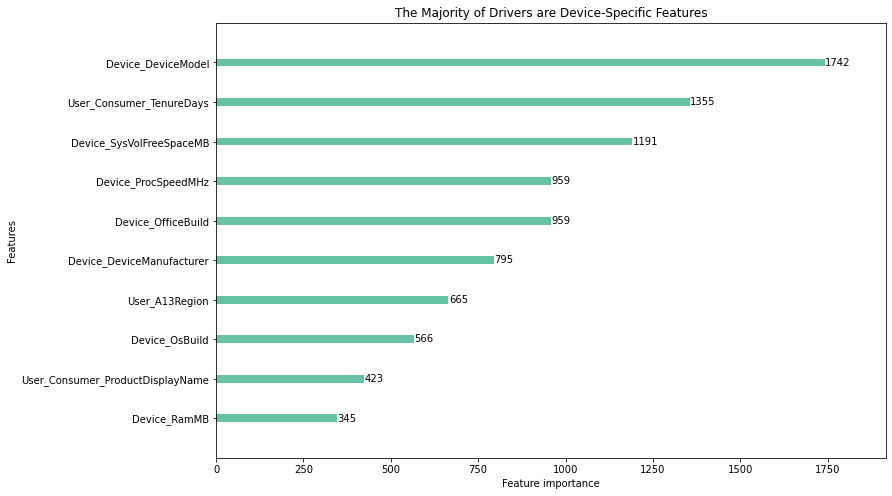

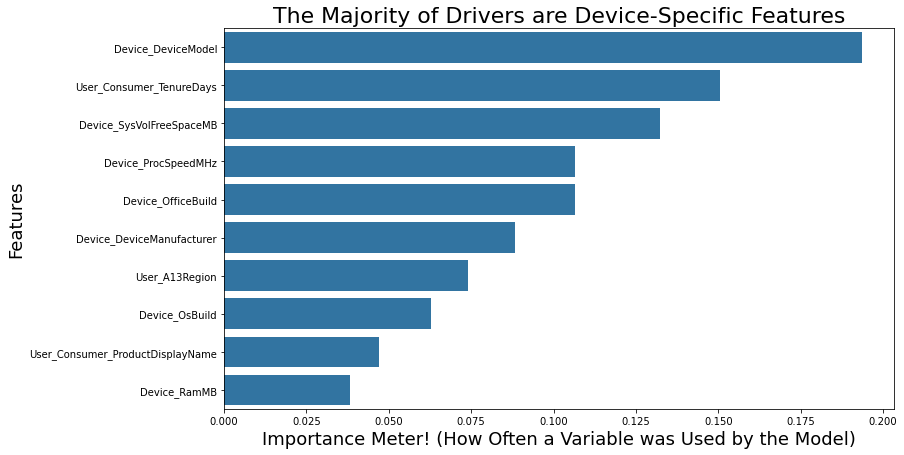

In [8]:
outlook_windows_consumer_drivers = driver_analysis.find_drivers(outlook_windows_consumer_drivers, 'The Majority of Drivers are Device-Specific Features')

Shape before: (12656, 251)
Shape after throwing out useless features: (12656, 159)


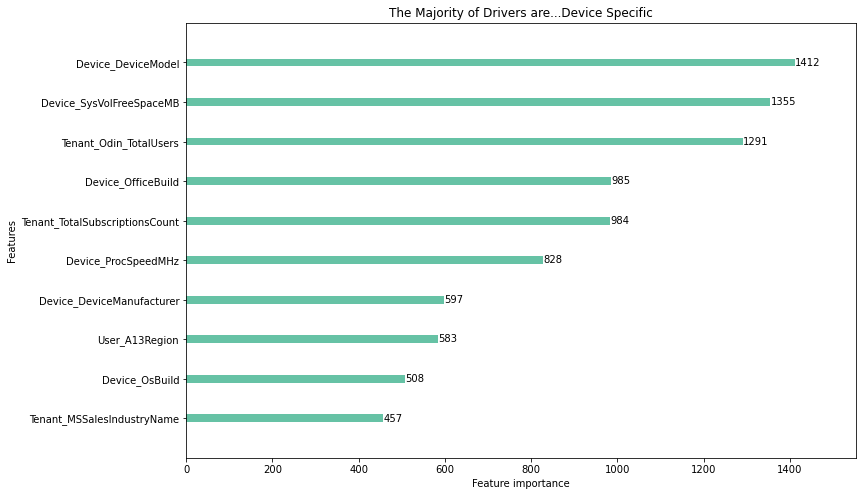

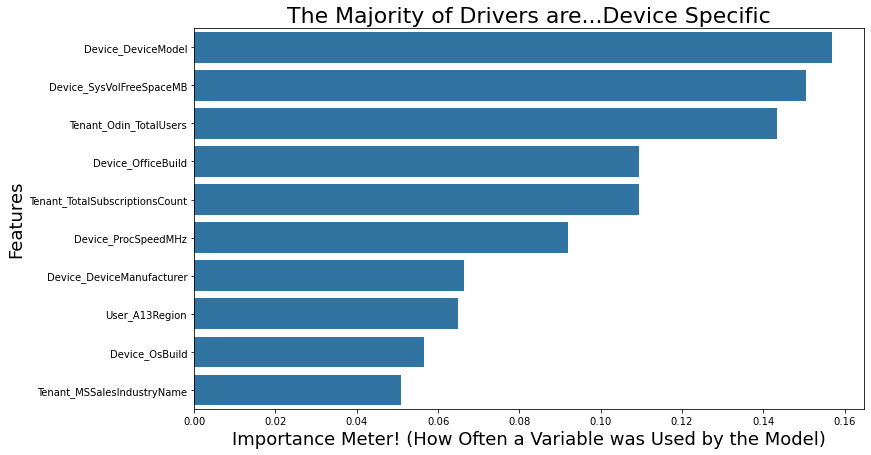

In [9]:
comedu_drivers = driver_analysis.find_drivers(outlook_windows_comedu_drivers, 'The Majority of Drivers are...Device Specific')

Shape before: (73978, 251)
Shape after throwing out useless features: (73978, 159)


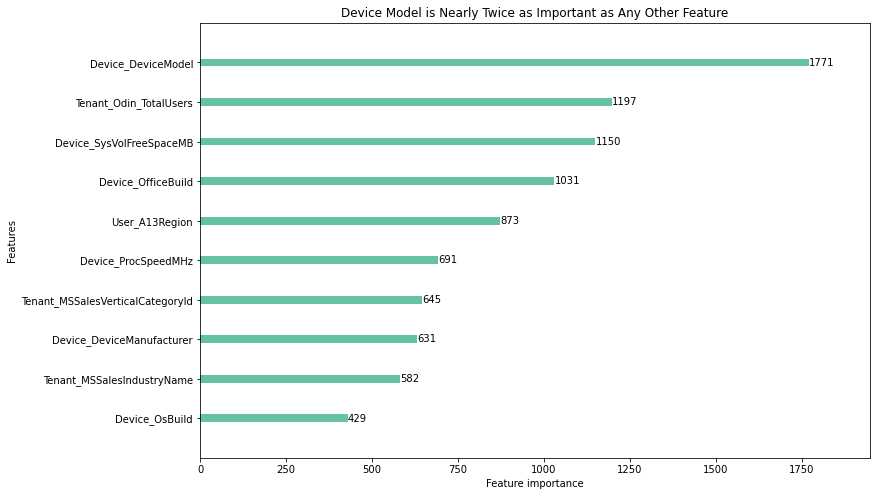

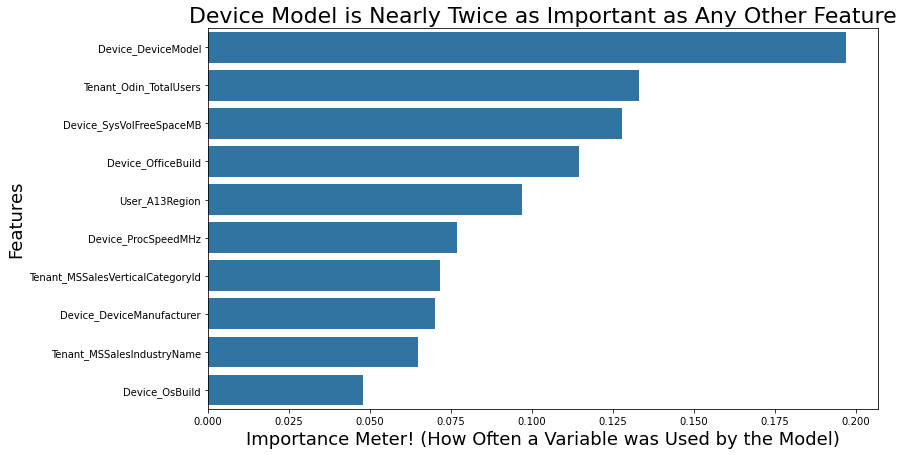

In [10]:
nonedu_drivers = driver_analysis.find_drivers(outlook_windows_nonedu_drivers, 'Device Model is Nearly Twice as Important as Any Other Feature')

In [125]:
trends = pd.read_csv('Outlook 13 Month NPS Trends.csv')

trends['Feedback_Platform'].unique()

trends = pd.concat([pd.DataFrame(trends[trends['Feedback_Platform'] == 'windows commercial edu'].iloc[:, 0]), 
                    pd.DataFrame(trends[trends['Feedback_Platform'] == 'windows consumer'].iloc[:, 0]), 
pd.DataFrame(trends[trends['Feedback_Platform'] == 'windows commercial non-edu'].iloc[:, 0]),
                    pd.DataFrame(trends[trends['Feedback_Platform'] == 'windows all up combined'].iloc[:, 0]), trends[['year', 'month']]], axis = 1)

trends.columns = ['comedu', 'consumer', 'nonedu', 'combined', 'year', 'month']

trends = trends.apply(lambda x: pd.Series(x.dropna().values)).iloc[:14, :]

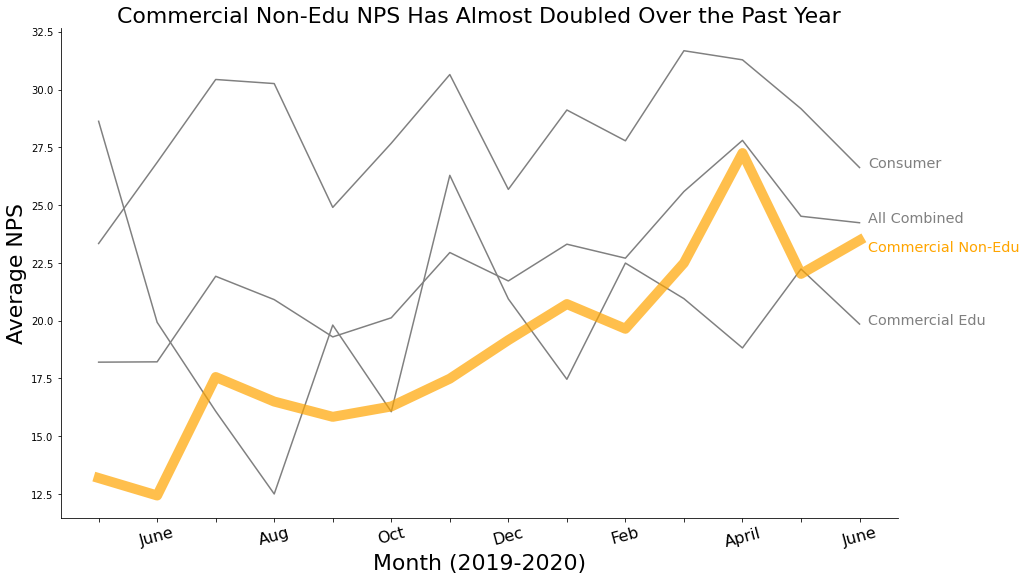

In [1163]:
for col in trends.drop(['year', 'month', 'nonedu'], axis =1):
        
    trends[col].plot(figsize = (15, 9), color = 'grey')
    
ax = trends['nonedu'].plot(marker = '', color = 'orange', linewidth = 10, alpha = .7)
#ax = trends['nonedu'].plot(marker = '', color = 'tab:blue', linewidth = 10, alpha = .7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.text(13.15, trends.combined.tail(1), 'All Combined', horizontalalignment='left', size='x-large', color='grey')
plt.text(13.15, 23, 'Commercial Non-Edu', horizontalalignment='left', size='x-large', color='orange')
plt.text(13.15, trends.comedu.tail(1), 'Commercial Edu', horizontalalignment='left', size='x-large', color='grey')
plt.text(13.15, trends.consumer.tail(1), 'Consumer', horizontalalignment='left', size='x-large', color='grey')

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], [' ', 'June', ' ', 'Aug', ' ', 'Oct', ' ', 'Dec', ' ', 'Feb', ' ', 
                                                           'April', ' ', 'June'], fontsize = 16, rotation = 15)

plt.title("Commercial Non-Edu NPS Has Almost Doubled Over the Past Year", fontsize = 22)
plt.ylabel('Average NPS', fontsize = 22)
plt.xlabel('Month (2019-2020)', fontsize = 22);

In [34]:
outlook_windows_drivers['User_Consumer_TenureDays'] = pd.cut(outlook_windows_drivers['User_Consumer_TenureDays'], bins = [0, 30, 90, 270, 365, 730, 1095, 1460, 1825, 2190, 1000000],
                                                            labels = ['< 1 month', '1-3 months', '3-9 months', '9 months - 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-6 years',
                                                                     '6+ years'])

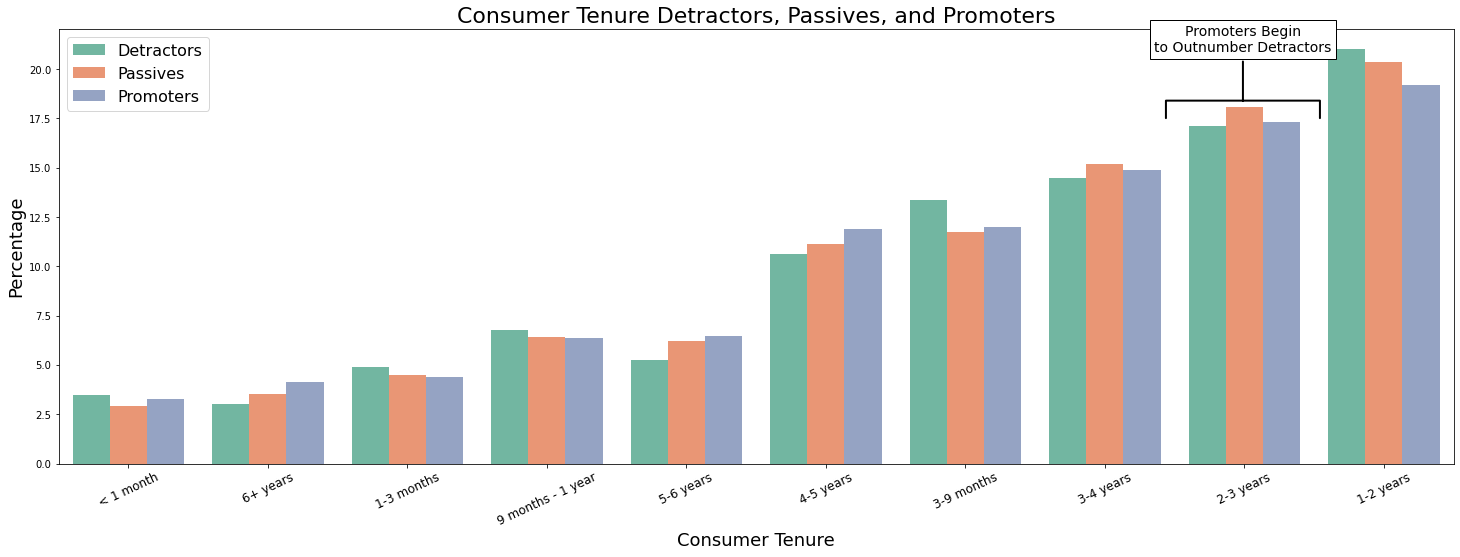

In [81]:
#top_20 = pd.DataFrame(outlook_windows_consumer_drivers['Device_DeviceModel'].value_counts().nlargest(20)).index
            
#plt_df = outlook_windows_consumer_drivers[outlook_windows_consumer_drivers['Device_DeviceModel'].isin(top_20)]
            
counts = (outlook_windows_drivers.groupby('Feedback_RatingValue')['User_Consumer_TenureDays'].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
            
plt.figure(figsize = (25, 8))
            
ax = sns.barplot(x = 'User_Consumer_TenureDays', y = 'percentage', hue = counts['Feedback_RatingValue'].map({-100:'Detractors', 0:'Passives', 100:'Promoters'}), data = counts,
                        order = counts.iloc[counts[counts['Feedback_RatingValue'] == 100]['percentage'].sort_values().index]['User_Consumer_TenureDays'])
            
plt.title(f'Consumer Tenure Detractors, Passives, and Promoters', fontsize = 22)
            
plt.xticks(rotation = 25, fontsize = 16)
                
plt.xlabel(f'Consumer Tenure', fontsize = 18)
                
plt.ylabel('Percentage', fontsize = 18)

plt.xticks(rotation = 25, fontsize = 12)

# fs = 14
# # Here is the label and arrow code of interest
ax.annotate('Promoters Begin\nto Outnumber Detractors', xy=(.849, .83), xytext=(.849, .94), xycoords='axes fraction', 
            fontsize=14, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=5.5, lengthB=1.25', lw=2.0))

# # # ax.get_xticklabels()[18].set_color("yellow")
# plt.annotate("Japan Has\nHighest %\nof Detractors", xy=(1.8, 6), xytext=(2, 8), arrowprops=dict(arrowstyle="simple"), fontsize = 12)
# plt.annotate("Middle East\nand Africa Have\nHigh %\nof Promoters", xy=(5.2, 5.3), xytext=(4.5, 8), arrowprops=dict(arrowstyle="simple"), fontsize = 12)
#plt.annotate("Again, Discrete Manufacturing\nhas the highest amount\nof Detractors", xy=(26.5, 12), xytext=(22, 14), arrowprops=dict(arrowstyle="simple"), fontsize = 12)

# plt.annotate("High Promoters", xy=(10, 9), xytext=(9, 13), arrowprops=dict(arrowstyle="simple"), fontsize = 18)
# plt.annotate("Surface Pro", xy=(17.5, 10), xytext=(14, 12), arrowprops=dict(arrowstyle="simple"), fontsize = 18)
# plt.annotate("Surface Pro", xy=(11, 4), xytext=(14, 12), arrowprops=dict(arrowstyle="simple"), fontsize = 18)
plt.legend(loc = 'upper left', fontsize = 16);

Text(2, 25, '')

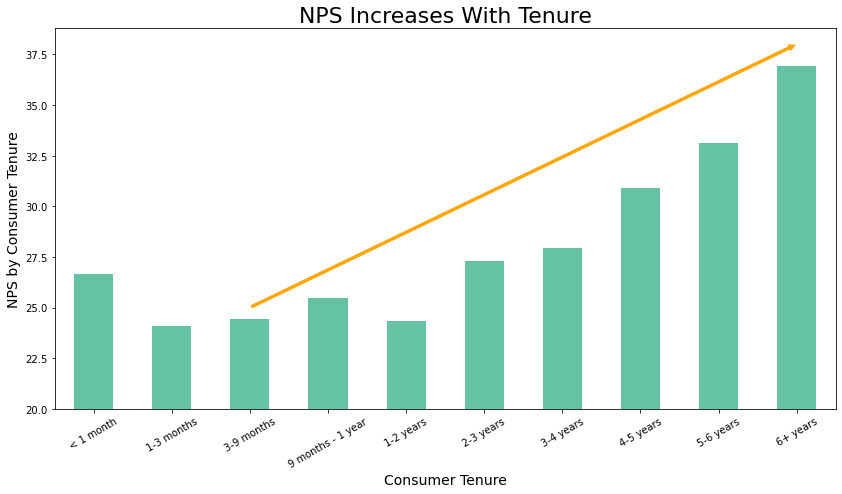

In [60]:
outlook_windows_drivers.groupby('User_Consumer_TenureDays').Feedback_RatingValue.mean().plot(kind = 'bar', figsize = (14, 7))
plt.xticks(rotation = 30)
plt.ylabel('NPS by Consumer Tenure', fontsize = 14)
plt.xlabel('Consumer Tenure', fontsize = 14)
plt.title('NPS Increases With Tenure', fontsize = 22)
plt.ylim(20)
plt.annotate("", xy=(9, 38), xytext=(2, 25), arrowprops=dict(arrowstyle="simple", color = 'orange'), fontsize = 12)

In [83]:
dm = outlook_windows_drivers[outlook_windows_drivers['Tenant_MSSalesIndustryName'] == 'Discrete Manufacturing']

In [102]:
energy = outlook_windows_drivers[outlook_windows_drivers['Tenant_MSSalesIndustryName'] == 'Energy']

# Left off at ProcSpeed, Start Here Next Time (plt.ylim(15))

Text(0.81, 0.1, 'Developing Regions')

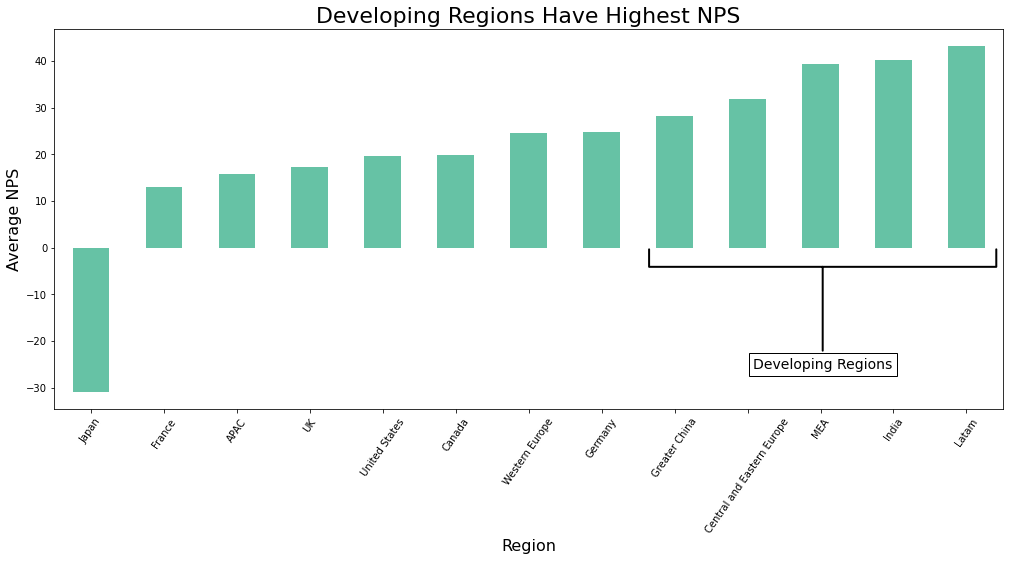

In [224]:
outlook_windows_drivers.groupby(['User_A13Region']).Feedback_RatingValue.mean().sort_values().plot(kind = 'bar', figsize = (17, 7))
plt.xticks(rotation = 55)
plt.title('Developing Regions Have Highest NPS', fontsize = 22)
plt.xlabel('Region', fontsize = 16)
plt.ylabel('Average NPS', fontsize = 16)
# ax.annotate('Developing Regions', xy=(.81, .38), xytext=(.81, .1), xycoords='axes fraction', 
#             fontsize=14, ha='center', va='bottom',
#             bbox=dict(boxstyle='square', fc='white'),
#             arrowprops=dict(arrowstyle='-[, widthB=12.4, lengthB=1.25', lw=2.0))

In [124]:
top_20 = [x for x in pd.DataFrame(outlook_windows_drivers['Device_DeviceModel'].value_counts().nlargest(20)).reset_index().iloc[:,0]]

In [125]:
top_20

['System Product Name',
 'Surface Pro 4',
 'Surface Pro',
 'All Series',
 'To Be Filled By O.E.M.',
 'To be filled by O.E.M.',
 'Latitude 5490',
 'Latitude 5480',
 'Latitude 7490',
 'Surface Pro 3',
 'Latitude 7480',
 'HP EliteBook 840 G3',
 'OptiPlex 3050',
 'Surface Book',
 'Surface Book 2',
 'HP Notebook',
 'HP EliteBook 840 G5',
 'Surface Pro 6',
 'Latitude E7470',
 'HP Pavilion Notebook']

In [126]:
devices = outlook_windows_drivers[outlook_windows_drivers['Device_DeviceModel'].isin(top_20)]

In [144]:
regions = []
for x in devices['User_A13Region']:
    
    if x == 'India':
        regions.append('India')
        
    elif x == 'Latam':
        regions.append('Latam')
        
    elif x == 'MEA':
        regions.append('MEA')
        
    else:
        regions.append('Other')

devices['User_A13Region'] = [x for x in regions]

C:\Users\fulto\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [151]:
device_plt_df = pd.DataFrame(devices.groupby('User_A13Region').Device_DeviceModel.value_counts(normalize = True)).rename(columns = {'Device_DeviceModel':'%'}).reset_index()

In [173]:
plt_df = device_plt_df[device_plt_df['Device_DeviceModel'].str.contains('Latitude 5490|HP Notebook|HP Pavilion Notebook')]

In [185]:
plt_df = pd.concat([pd.DataFrame(plt_df['User_A13Region'].unique()).rename(columns = {0:'Region'}), plt_df.groupby(plt_df.index // 20).sum()], axis = 1)

In [186]:
plt_df

,Region,%
0,India,0.290155
1,Latam,0.200334
2,MEA,0.209246
3,Other,0.092435


Text(0.5, 1.0, 'Developing Regions Have Higher % of Cheaper Devices (Top 3 Devices for this Segment)')

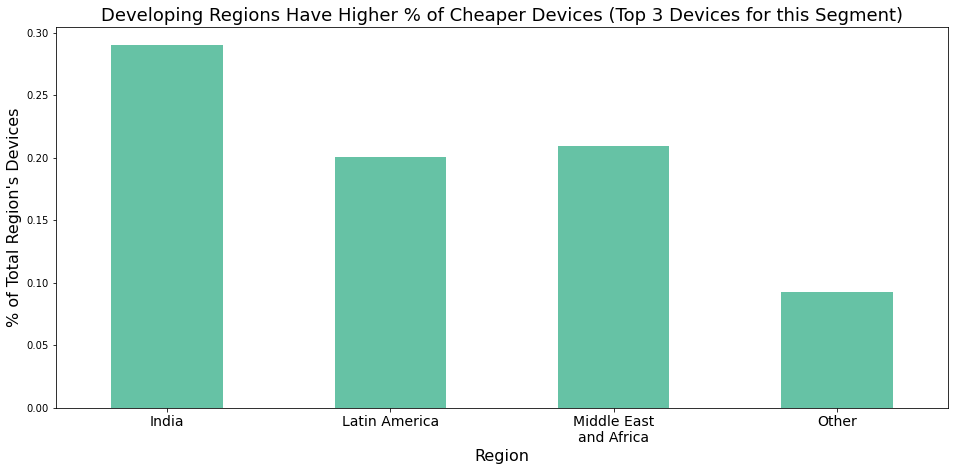

In [200]:
ax = plt_df.plot(kind = 'bar', figsize = (16, 7), legend = False)
ax.set_xticklabels(labels = ['India', 'Latin America', 'Middle East\nand Africa', 'Other'], fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('Region', fontsize = 16)
plt.ylabel("% of Total Region's Devices", fontsize = 16)
plt.title('Developing Regions Have Higher % of Cheaper Devices (Top 3 Devices for this Segment)', fontsize = 18)

Text(0.5, 1.0, 'Developing Regions Account for Higher Percentages of Dell Latitude Usage')

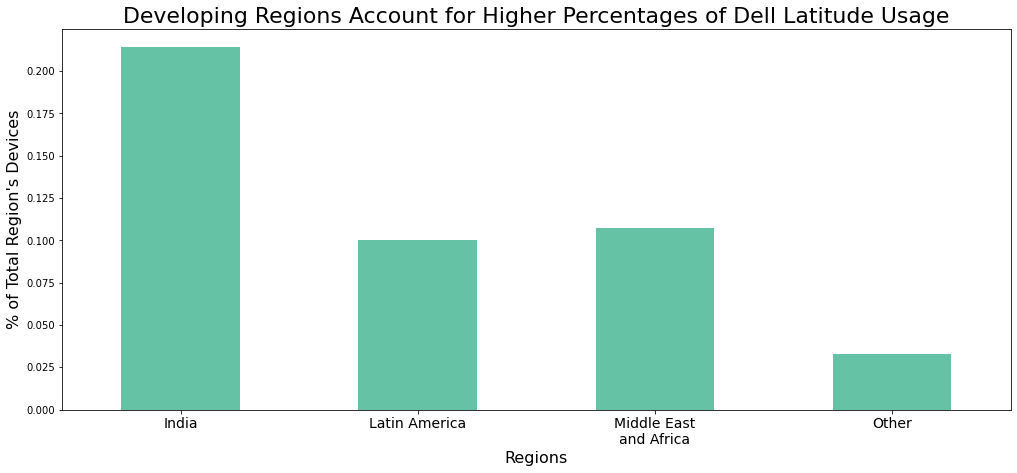

In [168]:
ax= plt_df[plt_df['Device_DeviceModel']].plot(kind = 'bar', figsize = (17, 7), legend = False)
ax.set_xticklabels(labels = ['India', 'Latin America', 'Middle East\nand Africa', 'Other'], fontsize = 14)
plt.xticks(rotation = 0)
plt.xlabel('Regions', fontsize = 16)
plt.ylabel("% of Total Region's Devices", fontsize = 16)
plt.title('Developing Regions Account for Higher Percentages of Dell Latitude Usage', fontsize = 22)

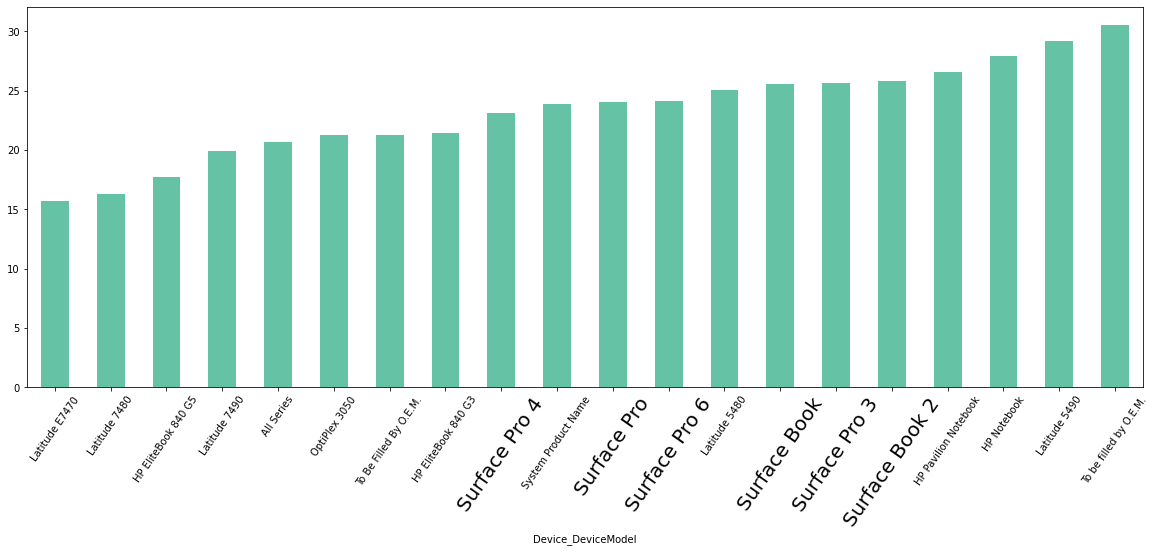

In [135]:
devices.groupby('Device_DeviceModel').Feedback_RatingValue.mean().sort_values().plot(kind = 'bar', figsize = (20, 7))
plt.xticks(rotation = 55)
font_sizes = [10, 10, 10, 10, 10, 10, 10, 10, 20, 10, 20, 20, 10, 20, 20, 20, 10, 10, 10, 10]

for tick, size in zip(plt.xticks()[-1], font_sizes):
    tick.set_fontsize(size)

Text(0.885, -1, 'Developing Regions')

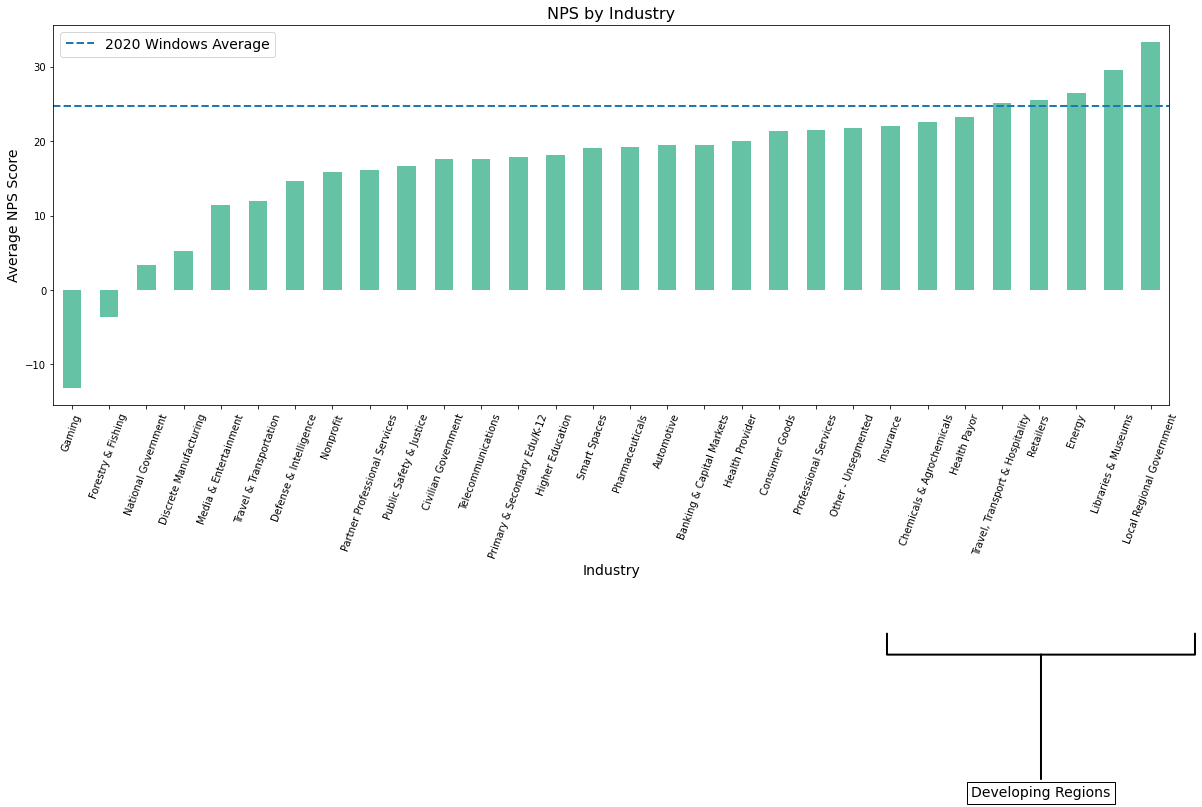

In [22]:
#plotting top 20 device models by NPS score 
top_20 = pd.DataFrame(outlook_windows_drivers['Tenant_MSSalesIndustryName'].value_counts(normalize = True).nlargest(20)).index
            
#creating df for levels in the top 20
plt_df = outlook_windows_drivers[outlook_windows_drivers['Tenant_MSSalesIndustryName'].isin(top_20)]
            
#creating figure size
plt.figure(figsize = (20, 7))
            
#plotting on a categorical variable using groupby
ax = nonedu_drivers.groupby('Tenant_MSSalesIndustryName').Feedback_RatingValue.mean().sort_values().plot(kind = 'bar')
            
#create title
plt.title(f'NPS by Industry', fontsize = 16)
            
#create y label
plt.ylabel('Average NPS Score', fontsize = 14)
            
#create x label
plt.xlabel('Industry', fontsize = 14)
            
plt.axhline(y=24.75, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall

# font_sizes = [10, 10, 10, 10, 10, 20, 20, 10, 10, 10, 20, 20, 10, 10, 10, 10, 20, 20, 10, 10]

# for tick, size in zip(plt.xticks()[-1], font_sizes):
#     tick.set_fontsize(size)

    
# plt.xticks(rotation = 55, fontsize = 10)
plt.xticks(rotation = 70)

#this code places a bracket around an area of interest
#https://stackoverflow.com/questions/35320437/drawing-brackets-over-plot
plt.legend(labels = ['2020 Windows Average'], fontsize = 14)

fs = 14
# Here is the label and arrow code of interest -- this creates a bracket that can wrap anything
ax.annotate('Developing Regions', xy=(0.885, -.65), xytext=(0.885, -1), xycoords='axes fraction', 
            fontsize=14, ha='center', va='top',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=11, lengthB=1.5', lw=2.0))

# plt.annotate("Discrete\nManufacturing", xy=(3, 5), xytext=(.2, 10), arrowprops=dict(arrowstyle="fancy"), fontsize = 14)
# plt.annotate("Energy", xy=(28, 26), xytext=(26, 28), arrowprops=dict(arrowstyle="fancy"), fontsize = 14)
# plt.annotate("Primary, Secondary\nand Higher Education", xy=(15, 17.5), xytext=(13, 28), arrowprops=dict(arrowstyle="fancy"), fontsize = 14)
# plt.annotate("", xy=(14, 17.5), xytext=(14.5, 27.8), arrowprops=dict(arrowstyle="fancy"), fontsize = 14)
# ;


# def autolabel(rects, ax):
#     # Get y-axis height to calculate label position from.
#     (y_bottom, y_top) = ax.get_ylim()
#     y_height = y_top - y_bottom

#     for rect in rects:
#         height = rect.get_height()

#         # Fraction of axis height taken up by this rectangle
#         p_height = (height / y_height)

#         # If we can fit the label above the column, do that;
#         # otherwise, put it inside the column.
#         if p_height > 0.95: # arbitrary; 95% looked good to me.
#             label_position = height - (y_height * 0.05)
#         else:
#             label_position = height + (y_height * 0.01)

#         ax.text(rect.get_x() + rect.get_width()/2., label_position,
#                 '%d' % int(height),
#                 ha='center', va='bottom')
        

        
# autolabel([x for x in top_20_df['Device_OsBuild']], ax)

Text(0.5, 0, 'Industry')

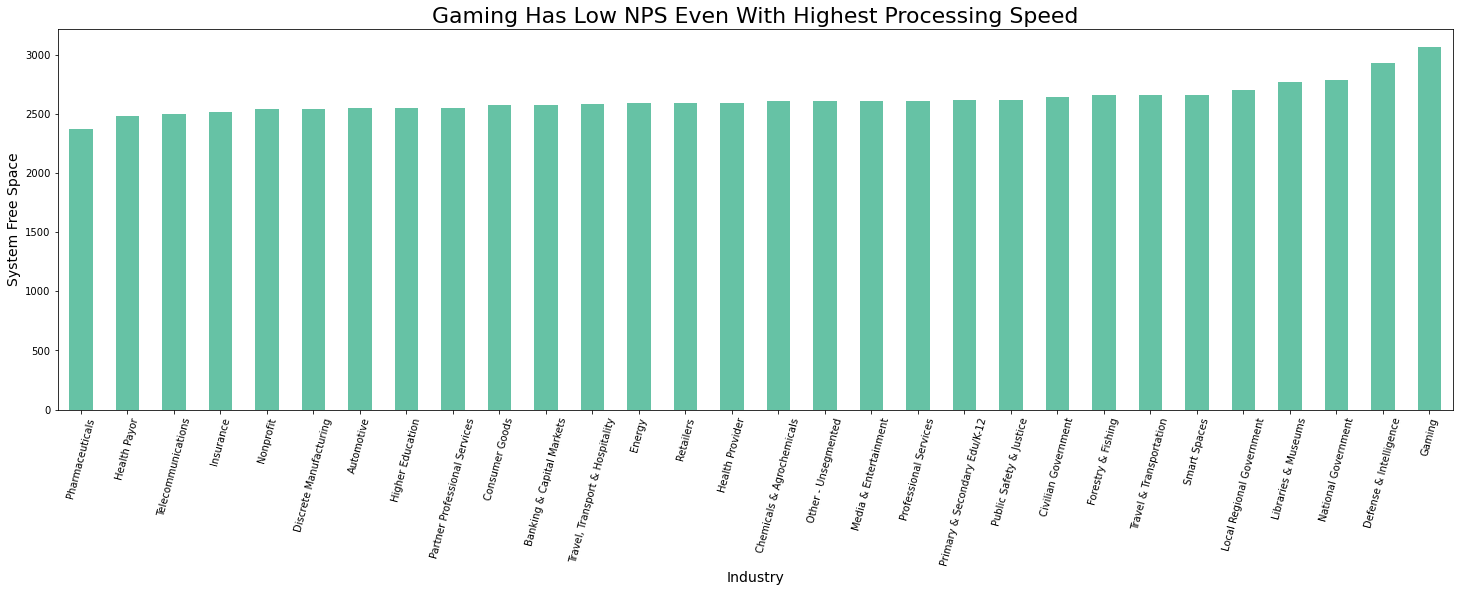

In [1462]:
nonedu_drivers.groupby('Tenant_MSSalesIndustryName').Device_ProcSpeedMHz.mean().sort_values().plot(kind = 'bar', figsize = (25, 7))
plt.xticks(rotation = 75)
plt.title('Gaming Has Low NPS Even With Highest Processing Speed', fontsize = 22)
plt.ylabel('System Free Space', fontsize = 14)
plt.xlabel('Industry', fontsize = 14)
#plt.annotate("Gaming", xy=(29, 3000), xytext=(27, 3000), arrowprops=dict(arrowstyle="fancy"), fontsize = 16);

In [1470]:
top_cats = pd.DataFrame(nonedu_drivers['Tenant_MSSalesVerticalCategoryId'].value_counts().nlargest(20)).index

In [1471]:
top_20_cats = nonedu_drivers[nonedu_drivers['Tenant_MSSalesVerticalCategoryId'].isin(top_cats)]

Text(15, -23, 'Surface Pro 4\n has more Detractors\n than Promoters')

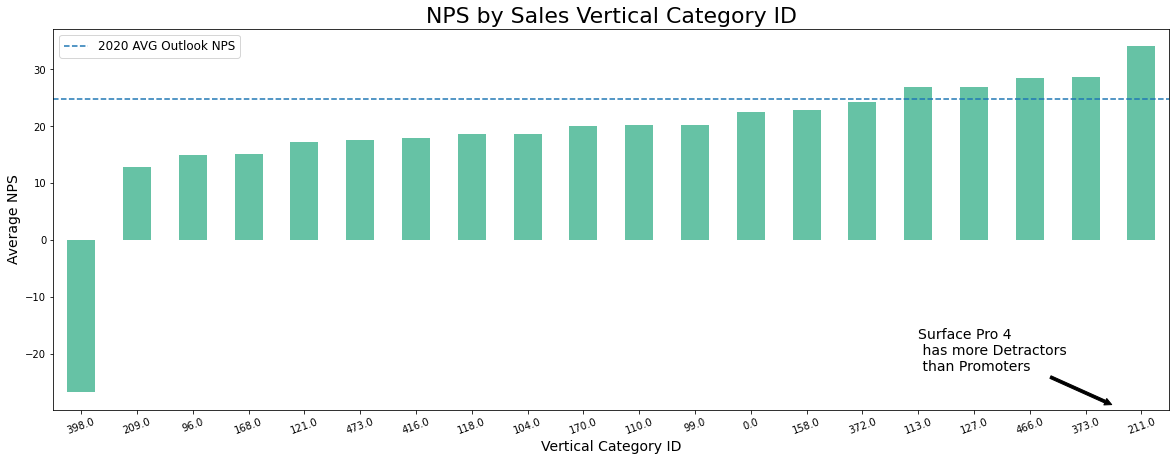

In [1555]:
top_20_cats.groupby('Tenant_MSSalesVerticalCategoryId').Feedback_RatingValue.mean().sort_values().plot(kind = 'bar', figsize = (20, 7))
plt.title('NPS by Sales Vertical Category ID', fontsize = 22)
plt.axhline(24.75, linestyle = '--', color = 'tab:blue')
plt.legend(labels = ['2020 AVG Outlook NPS'], fontsize = 12)
plt.xticks(rotation = 20)
plt.ylabel('Average NPS', fontsize = 14)
plt.xlabel('Vertical Category ID', fontsize = 14)
plt.annotate("Surface Pro 4\n has more Detractors\n than Promoters",
             xy=(18.5, -29), xytext=(15, -23), arrowprops=dict(arrowstyle="simple", color = 'black'), fontsize = 14)

In [708]:
outlook_windows_drivers['User_Consumer_TenureDays'] = pd.cut(outlook_windows_drivers['User_Consumer_TenureDays'], 
                                                           bins = [0, 100, 250, 365, 730, 1095, 1460, 1825, 2190, 2571], labels = ['< 3 months', '3-9 months', 
                    '9 months-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years', '6+ Years'])

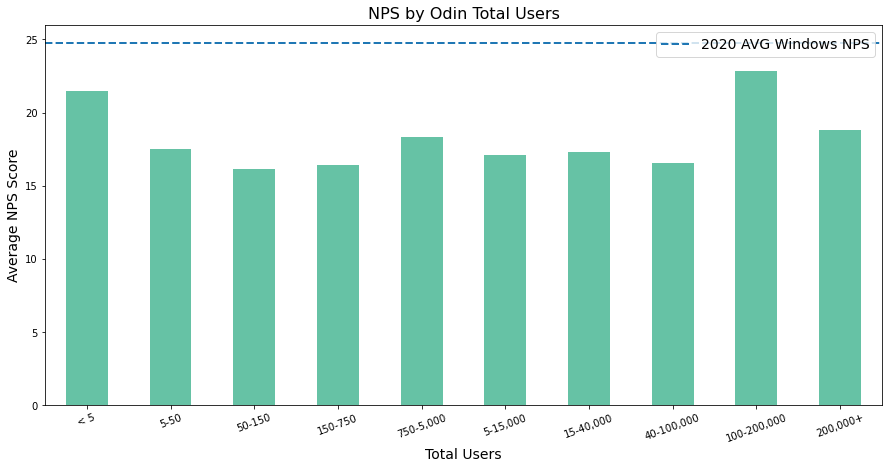

In [494]:
driver_analysis.numeric_plot_structure(24.75, outlook_windows_drivers, 'Tenant_Odin_TotalUsers', 'windows', 'NPS by Odin Total Users', 'Total Users', 
                                       bins = [0, 5, 50, 150, 750, 5000, 15000, 40000, 100000, 200000, 10000000000000],
                          labels = ['< 5', '5-50', '50-150', '150-750', '750-5,000', '5-15,000', '15-40,000', '40-100,000', '100-200,000', '200,000+'], method = 'cut')

In [727]:
def janky_plot_function(df, feature):
    
    a = pd.DataFrame(df.groupby('Feedback_RatingValue')[feature].value_counts(normalize = True).rename('percentage').mul(100).reset_index())
    
    plt.figure(figsize = (25, 10))
    sns.barplot(x = feature, y = 'percentage', hue= a['Feedback_RatingValue'].map({-100:'Detractors', 0:'Passives', 100:'Promoters'}), data = a, order = a.iloc[a[a['Feedback_RatingValue'] == 100]['percentage'].sort_values().index][feature])
    plt.title(f'{feature} Detractors, Passives, and Promoters', fontsize = 22)
    plt.xlabel(feature, fontsize = 16)
    plt.ylabel('Percentage', fontsize = 16)
    plt.legend(fontsize = 12)

In [766]:
top = pd.DataFrame(outlook_windows_drivers['Device_DeviceManufacturer'].value_counts().nlargest(20)).reset_index().rename(columns={'index':'company'})

In [767]:
top

,company,Device_DeviceManufacturer
0,Dell Inc.,35971
1,LENOVO,24717
2,HP,24255
3,Microsoft Corporation,9680
4,Hewlett-Packard,8210
5,ASUSTeK COMPUTER INC.,6054
6,Acer,5096
7,System manufacturer,4426
8,TOSHIBA,1860
9,"Gigabyte Technology Co., Ltd.",1625


In [882]:
janky_plot_function(outlook_windows_consumer_drivers, 'User_Consumer_TenureDays')
plt.xticks(rotation = 20)


KeyboardInterrupt



<Figure size 1800x720 with 0 Axes>

In [853]:
a = pd.DataFrame(outlook_windows_drivers.groupby('User_A13Region').Tenant_MSSalesIndustryName.value_counts(normalize = True))
a.columns = ['Percentage']

In [854]:
a.reset_index(inplace = True)
a.columns = ['Region', 'Industry', 'Percentage'] 

In [855]:
b = a[a['Industry'] == 'Energy']

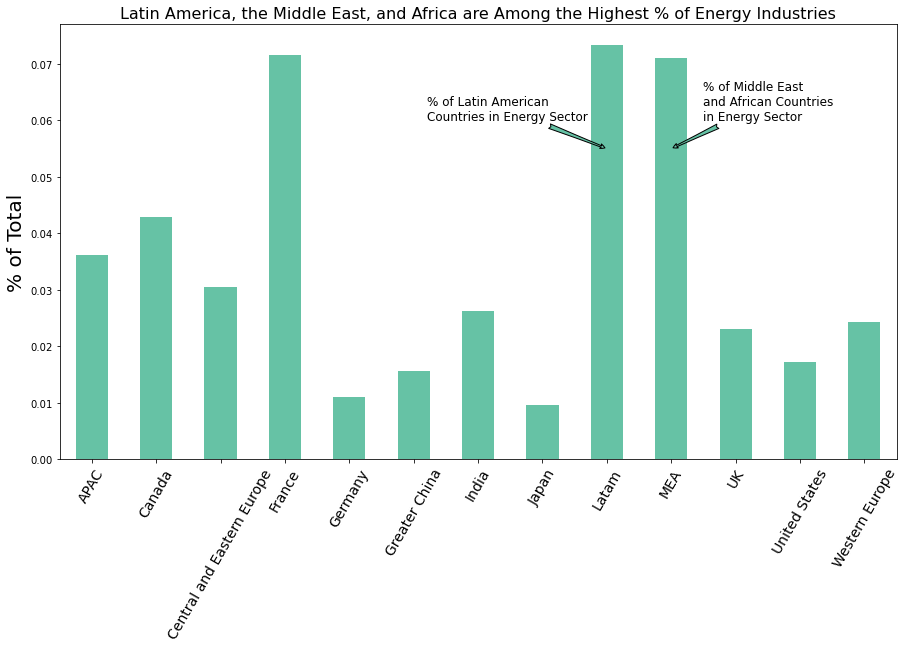

In [858]:
ax = b[b['Industry'] == 'Energy'].plot(kind = 'bar', figsize = (15, 8))
plt.xticks(rotation = 0)
plt.title('Latin America, the Middle East, and Africa are Among the Highest % of Energy Industries', fontsize = 16)
plt.xlabel('', fontsize = 20)
plt.ylabel('% of Total', fontsize = 20)
ax.set_xticklabels(labels = [x for x in b['Region']], fontsize = 14)
ax.get_legend().remove()
plt.xticks(rotation = 60)
plt.annotate("% of Latin American\nCountries in Energy Sector", xy=(8, .055), xytext=(5.2 ,.06), arrowprops=dict(arrowstyle="fancy"), fontsize = 12);
plt.annotate("% of Middle East\nand African Countries\nin Energy Sector", xy=(9, .055), xytext=(9.5, .06), arrowprops=dict(arrowstyle="fancy"), fontsize = 12);

In [565]:
toy_data_set = outlook_windows_drivers.copy()

In [664]:
countries = []
for x in toy_data_set['User_A13Region']:
    
    if x == 'Latam':
        
        countries.append('Latam')
    else:
        
        countries.append('Other')

toy_data_set['Country'] = [x for x in countries]

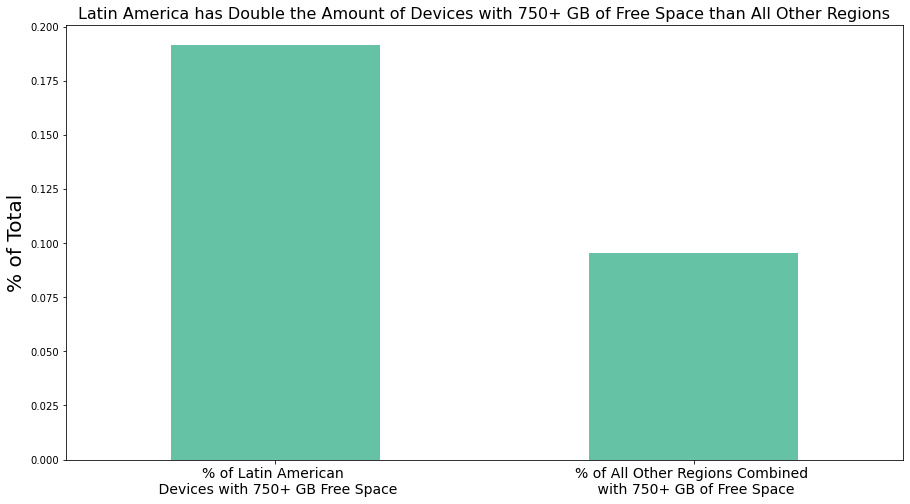

In [674]:
ax = pd.DataFrame(toy_data_set.groupby('Country').Device_SysVolFreeSpaceMB.value_counts(normalize= True)).iloc[[0, 14], :].plot(kind = 'bar', figsize = (15, 8))
plt.xticks(rotation = 0)
plt.title('Latin America has Double the Amount of Devices with 750+ GB of Free Space than All Other Regions', fontsize = 16)
plt.xlabel('', fontsize = 20)
plt.ylabel('% of Total', fontsize = 20)
ax.set_xticklabels(labels = ['% of Latin American \n Devices with 750+ GB Free Space', '% of All Other Regions Combined \n with 750+ GB of Free Space'], fontsize = 14)
ax.get_legend().remove()

In [636]:
#outlook_windows_drivers.groupby('User_A13Region').Device_SysVolFreeSpaceMB.value_counts(normalize= True)

In [1301]:
os_freq = pd.DataFrame(outlook_windows_nonedu_drivers['Device_OsBuild'].value_counts().nlargest(20))

In [1302]:
windows_nonedu_months_old = [10, 1, 4, 1, 4, 10, 4, 55, 60, 1, 7, 30, 28, 33, 21, 35, 7, 6, 32, 22]

In [1303]:
o = outlook_windows_nonedu_drivers[outlook_windows_nonedu_drivers['Device_OsBuild'].isin(os_freq.index)]

In [1304]:
outlook_windows_nonedu_os = pd.DataFrame(o.groupby(['Device_OsBuild']).Feedback_RatingValue.mean()).reset_index()

In [1305]:
outlook_windows_nonedu_os['build_age'] = windows_nonedu_months_old

In [1306]:
outlook_windows_nonedu_os['build_age'] = pd.cut(outlook_windows_nonedu_os['build_age'], bins = [0, 6, 12, 24, 36, 60], labels = ['< 6 months', '6 months - 1 year', '1-2 years', 
                                                                                                                      '2-3 years', '3-5 years'])

In [1309]:
outlook_windows.head(1)

,Feedback_ID,Feedback_DateTime,Feedback_Source,Feedback_Platform,Feedback_UserType,Feedback_TenantId,Feedback_Rating,Feedback_Verbatim,Feedback_SurveyName,Feedback_RatingValue,Feedback_RatingScale,Feedback_SystemLocale,Feedback_SurveyFlightName,Feedback_IsValidFlight,Feedback_App,Feedback_VerbatimLanguage,Feedback_SourceVerbatim,Feedback_OcvId1,Device_OfficeBuild,Device_OsBuild,Device_OsUserLocale,Device_Channel,Device_OsName,Device_OsSku,Device_OfficeUiLanguage,Device_OsLocaleTag,Device_ClientCountry,Device_FirstRunTime,Device_DeviceManufacturer,Device_DeviceModel,Device_OfficeArchitectureText,Device_ProcTypeText,Device_ProcessorCount,Device_ProcSpeedMHz,Device_RamMB,Device_NumProcPhysCores,Device_SysVolSizeMB,Device_SysVolFreeSpaceMB,Device_HorizontalResolution,Device_VerticalResolution,Device_ScreenDpi,Device_InstallType,Device_OfficeLicensingACID_LicenseName,User_SurveyId,User_Country,User_A13Region,User_LicenseModel,User_Commercial_TenantState,User_Commercial_TenantName,User_Commercial_MSSalesTopParentOrgId,User_Commerical_MSSalesTopParentOrgName,User_Commercial_TotalEnabledUsers,User_Commercial_HasEducation,User_Commercial_TotalAvailableUnits,User_Commercial_CreateDateOfFirstSubscription,User_Consumer_SubscriptionCreateDate,User_Consumer_TenureDays,User_Consumer_TenureBucket,User_Consumer_State,User_Consumer_LicenseType,User_Consumer_ProductDisplayName,User_Audience,User_AudienceGroup,User_IsCloudUser,Tenant_Name,Tenant_Type,Tenant_State,Tenant_CreatedDate,Tenant_IsTest,Tenant_IsViral,Tenant_IsFastTrackTenant,Tenant_DataCenterModel,Tenant_DataCenterInstance,Tenant_HasEducation,Tenant_HasCharity,Tenant_HasGovernment,Tenant_HasNonProfit,Tenant_IsM365,Tenant_HasM365PaidSeats,Tenant_HasM365SKUBusiness,Tenant_HasM365SKUEdu,Tenant_HasM365SKUF1,Tenant_HasM365SKUE3,Tenant_HasM365SKUE5,Tenant_HasOfficeSKUE1,Tenant_HasOfficeSKUE3,Tenant_HasOfficeSKUE4,Tenant_HasOfficeSKUE5,Tenant_HasQuickStart,Tenant_HasExchange,Tenant_HasLync,Tenant_HasSharePoint,Tenant_HasYammer,Tenant_HasSubscription,Tenant_HasProject,Tenant_HasNonTrial,Tenant_HasVisio,Tenant_HasTrial,Tenant_City,Tenant_Country,Tenant_CountryCode,Tenant_Region,Tenant_CommunicationLanguage,Tenant_BisLastUpdated,Tenant_IsMSODSDeleted,Tenant_IsRestrictRmsViralSignUp,Tenant_CompanyLastDirSyncTime,Tenant_TimeSinceLastDirSync,Tenant_DirectoryExtensionsSyncEnabled,Tenant_DirSyncEnabled,Tenant_PasswordSyncEnabled,Tenant_PasswordSyncTime,Tenant_TimeSinceLastPasswordSync,Tenant_PasswordWriteBackEnabled,Tenant_CreateDateOfFirstSubscription,Tenant_Tenure,Tenant_EDUSubscriptionsCount,Tenant_ExchangeSubscriptionsCount,Tenant_LyncSubscriptionsCount,Tenant_NonTrialSubscriptionsCount,Tenant_ProjectSubscriptionsCount,Tenant_SharePointSubscriptionsCount,Tenant_TotalSubscriptionsCount,Tenant_TrialSubscriptionsCount,Tenant_VisioSubscriptionsCount,Tenant_TenantStatus,Tenant_TenantCategory,Tenant_TotalAvailableUnits,Tenant_TrialAvailableUnits,Tenant_NonTrialAvailableUnits,Tenant_ProPlusAvailableUnits,Tenant_EXOAvailableUnits,Tenant_SPOAvailableUnits,Tenant_OD4BAvailableUnits,Tenant_LYOAvailableUnits,Tenant_YammerAvailableUnits,Tenant_TeamsAvailableUnits,Tenant_IsDonMT,Tenant_IsConcierge,Tenant_HasPartnerTenants,Tenant_EXOEnabledUsers,Tenant_SPOEnabledUsers,Tenant_LYOEnabledUsers,Tenant_PPDEnabledUsers,Tenant_OD4BEnabledUsers,Tenant_TeamEnabledUsers,Tenant_YammerEnabledUsers,Tenant_TotalEnabledUsers,Tenant_MSSalesCustomerOrgName,Tenant_MSSalesCustomerOrgId,Tenant_MSSalesTopParentOrgName,Tenant_MSSalesTopParentOrgId,Tenant_MSSalesCity,Tenant_MSSalesState,Tenant_MSSalesPostalCode,Tenant_MSSalesCountryCode,Tenant_MSSalesTPSubsidiaryId,Tenant_MSSalesSubSegmentId,Tenant_MSSalesVerticalCategoryId,Tenant_MSSalesSubsidiarySubDistrictId,Tenant_MSSalesCountryName,Tenant_MSSalesCurrencyCode,Tenant_MSSalesSubsidiaryName,Tenant_MSSalesEmergingMarket,Tenant_MSSalesSubsidiaryPeerGroupingName,Tenant_MSSalesSubRegionName,Tenant_MSSalesSubRegionClusterGroupingName,Tenant_MSSalesRegionName,Tenant_MSSalesAreaName,Tenant_

In [1354]:
comedu_drivers['Tenant_TotalSubscriptionsCount'] = pd.cut(comedu_drivers['Tenant_TotalSubscriptionsCount'], 
                                                                          bins = [0, 100, 200, 300, 400],
                                                                         labels = ['< 100', '100-200', '200-300', '300+'])

Text(0.5, 1.0, 'NPS by Tenant Total Subscription Count')

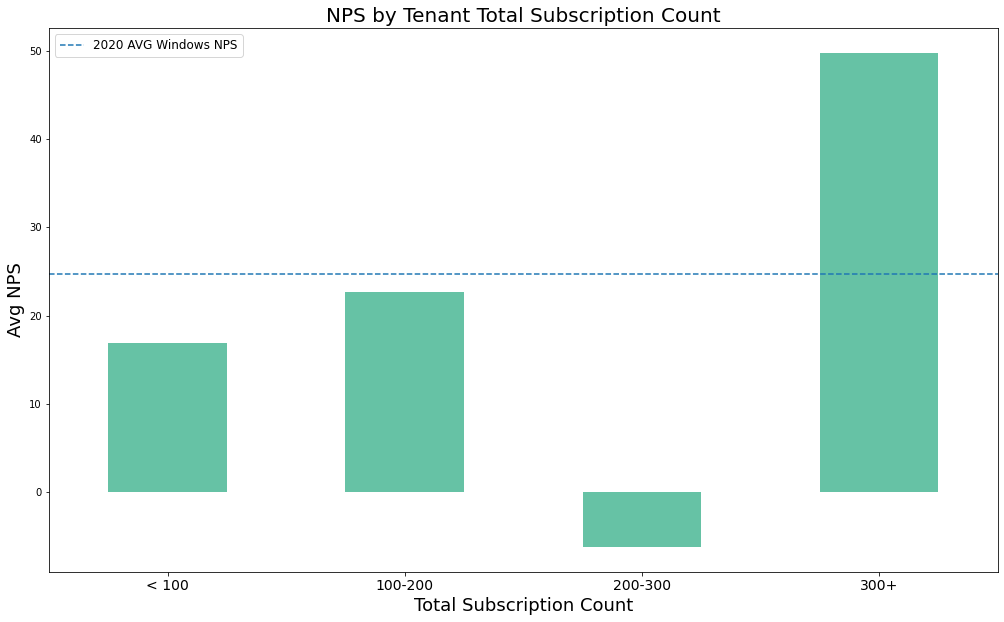

In [1357]:
comedu_drivers.groupby('Tenant_TotalSubscriptionsCount').Feedback_RatingValue.mean().plot(kind = 'bar', figsize = (17, 10))
plt.axhline(24.75, linestyle = '--', color = 'tab:blue')
plt.legend(labels = ['2020 AVG Windows NPS'], fontsize = 12)
plt.xticks(rotation = 0, fontsize = 14)
plt.xlabel('Total Subscription Count', fontsize = 18)
plt.ylabel('Avg NPS', fontsize = 18)
plt.title('NPS by Tenant Total Subscription Count', fontsize = 20)
#plt.annotate("Microsoft", xy=(2.5, 15), xytext=(2.3, 20), arrowprops=dict(arrowstyle="simple", color = 'black'), fontsize = 14);

In [1125]:
outlook_windows_drivers_w_age = outlook_windows_os.merge(outlook_windows_drivers, on = 'Device_OsBuild', how = 'inner')

In [1128]:
outlook_windows_drivers_w_age.rename(columns = {'Feedback_RatingValue_y':'Feedback_RatingValue'}, inplace = True)

In [1054]:
top_devices = outlook_windows_drivers.Device_DeviceModel.value_counts().nlargest(20).index
top_devs = outlook_windows_drivers[outlook_windows_drivers['Device_DeviceModel'].isin(top_devices)]

In [1055]:
regions = []
for x in top_devs['User_A13Region']:
    
    if x == 'Latam':
        
        regions.append('Latam')
    
    elif x == 'MEA':
        
        regions.append('MEA')
        
    elif x == 'India':
        
        regions.append('India')
        
    else:
        
        regions.append('Other')
        
top_devs['regions'] = [x for x in regions]

C:\Users\fulto\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1057]:
region_devs = pd.DataFrame(top_devs.groupby('regions').Device_DeviceModel.value_counts(normalize = True)).rename(columns = {'Device_DeviceModel':'percent'}).reset_index()

Text(0.5, 1.0, '% of Latitude 5490 Usage Across All Regions')

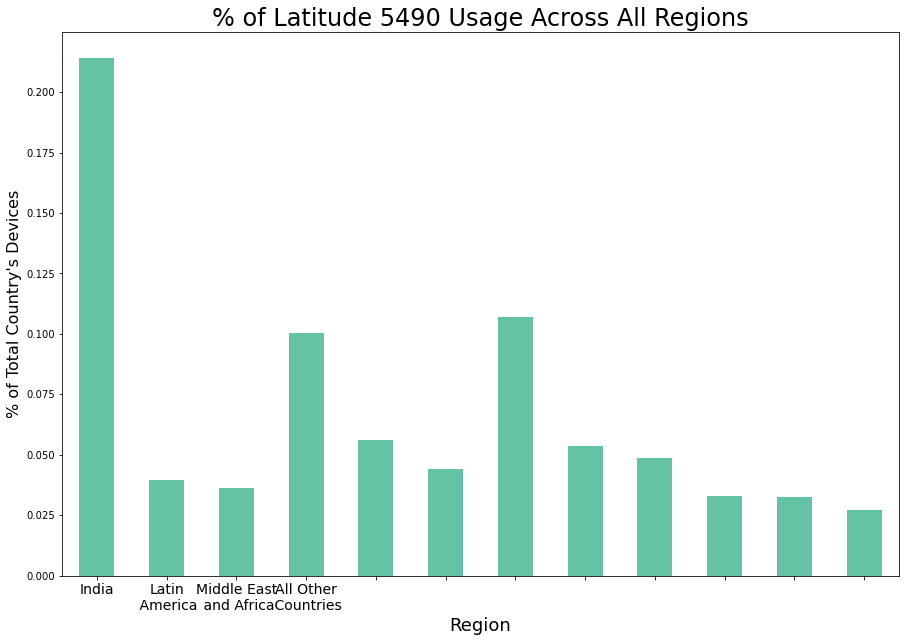

In [1093]:
ax = region_devs.iloc[[0, 8, 10, 21, 26, 29, 41, 46, 49, 75, 76, 79], :]['percent'].plot(kind = 'bar', figsize = (15, 10))
ax.set_xticklabels(['India', 'Latin\n America', 'Middle East\n and Africa', 'All Other\n Countries'])
plt.xticks(rotation = 0, fontsize = 14)
plt.ylabel("% of Total Country's Devices", fontsize = 16)
plt.xlabel('Region', fontsize = 18)
plt.title('% of Latitude 5490 Usage Across All Regions', fontsize = 24)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text major ticklabel objects>)

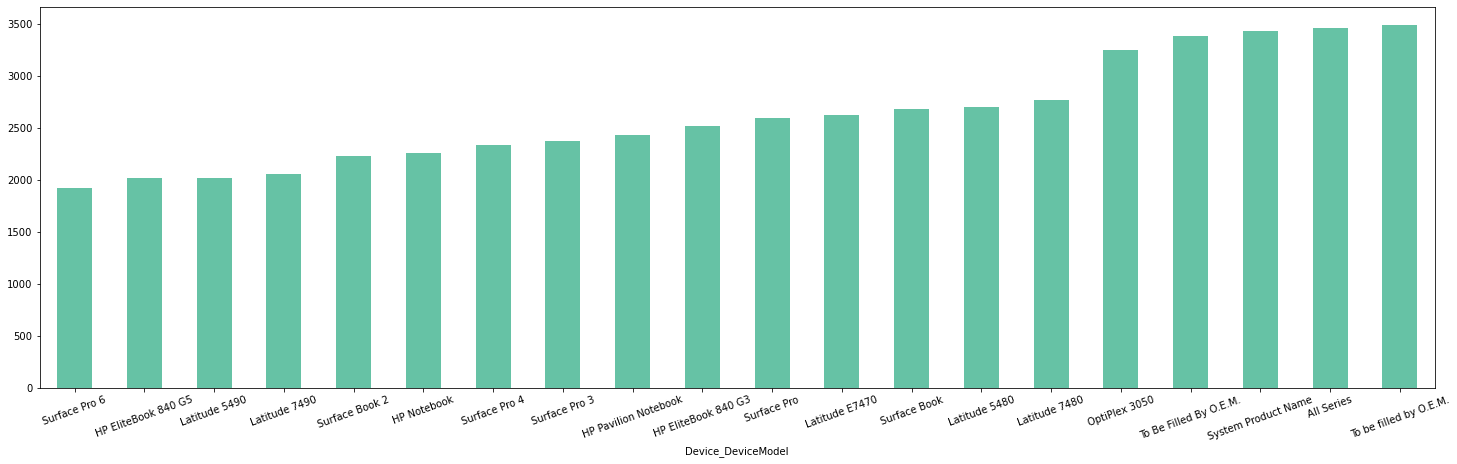

In [1101]:
top_devs.groupby('Device_DeviceModel').Device_ProcSpeedMHz.mean().sort_values().plot(kind= 'bar', figsize =(25, 7))
plt.xticks(rotation = 20)

In [1135]:
outlook_windows_consumer_drivers['Device_RamMB'] = pd.cut(outlook_windows_consumer_drivers['Device_RamMB'], bins = [0, 4000, 8000, 16000, 50000, 100000],
                              labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'])

Text(0.5, 1.0, 'Devices with Higher RAM Have Lowest NPS')

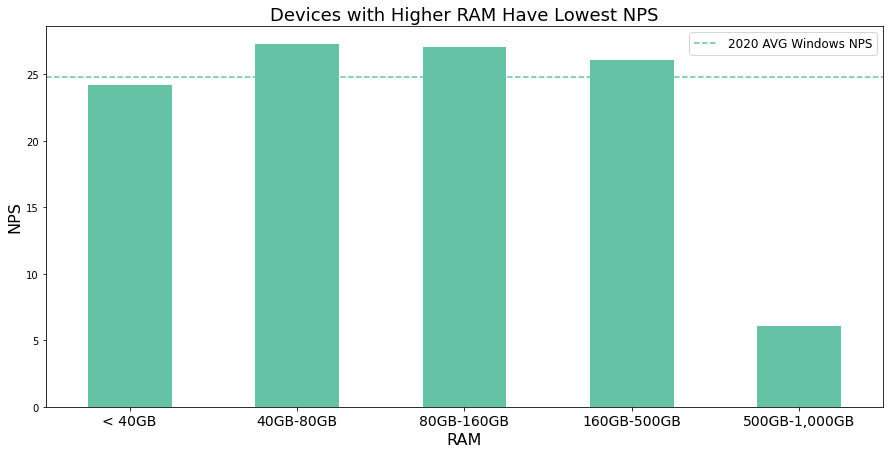

In [1147]:
outlook_windows_consumer_drivers.groupby('Device_RamMB').Feedback_RatingValue.mean().plot(kind = 'bar', figsize = (15, 7))
plt.xticks(rotation = 0, fontsize = 14)
plt.axhline(24.75, linestyle = '--')
plt.legend(labels = ['2020 AVG Windows NPS'], fontsize = 12)
plt.xlabel('RAM', fontsize = 16)
plt.ylabel('NPS', fontsize = 16)
plt.title('Devices with Higher RAM Have Lowest NPS', fontsize = 18)